## HANK
Using the methods presented already to solve and estimate a heterogeneous agent (HA) New Keynesian (NK) model.

#### Preliminaries

In [1]:
## load some packages
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy import sparse
import numba as nb
import numpy as np

## config
# params
BETA = 0.95
GAMMA = 2.
NU = 2.
PHI = 0.75
PSI = 6.
THETA = 0.75
OMEGA = 1.5
B_BAR = 0.6
RHO_z = 0.9
SIGMA_z = 0.1
N_z = 7  # number of idiosyncratic states
RHO_Z = 0.9
SIGMA_Z = 0.01
RHO_xi = 0.9
SIGMA_xi = 0.01
A_MIN = 0.
Z_ss = 1.
xi_ss = 1.

# grid
A_MAX = 25
N_A = 501
GRID = np.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
The model will be a mostly standard HANK model with idiosyncratic productivity and endogenous labor.

**Households** There is a unit continuum of ex ante identical households that differ ex post through their realization of their own idiosyncratic productivity shocks. Households are indexed $i \in [0, 1]$ and have preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{c_{i, t}^{1-\gamma}}{1-\gamma} - \phi \frac{\ell_{i, t}^{1+\nu}}{1+\nu}\right).
$$

Households earn income and invest in risk-free bonds subject to the budget constraint
$$
    a_{i, t} + c_{i, t} = R_t a_{i, t-1} + W_t z_{i, t} \ell_{i, t} + D_t - \tau_t z_{i, t},
$$
face the borrowing constraint $a_{i, t} \geq \underline a$, and have productivity that evolves according to
$$
    \log z_{i, t} = \rho_z z_{i, t-1} + \varepsilon_{i, t}
$$
where $\varepsilon_{i, t} \sim \mathcal{N} (0, \sigma_z)$ which we discretize as a Rowenhorst process.

The household problem has the Lagrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{t=0}^\infty \beta^t \left(\frac{c_{i, t}^{1-\gamma}}{1-\gamma} - \phi \frac{\ell_{i, t}^{1+\nu}}{1+\nu} - \lambda_{i, t} \left(R_t a_{i, t-1} + W_t z_{i, t} \ell_{i, t} + D_t - \tau_t z_{i, t} - a_{i, t} - c_{i, t}\right) - \mu_{i, t} (a_{i, t} - \underline a)\right)
$$
which has the FOCs

\begin{align*}
    \lambda_{i, t} &= c_{i, t}^{-\gamma} \tag{$c_{i, t}$} \\
    \lambda_{i, t} &= \beta \lambda_{i, t+1} R_{t+1} + \mu_{i, t} \tag{$a_{i, t}$} \\
    \lambda_{i, t} &= \phi \frac{\ell_{i, t}^{1 + \nu}}{W_t z_{i, t}}. \tag{$\ell_{i, t}$}
\end{align*}

This gets the Euler Equation
$$
    c_{i, t}^{-\gamma} \geq \beta R_{t+1} c_{i, t+1}^{-\gamma}
$$
and intratemporal condition
$$
    c_{i, t}^{-\gamma} = \phi \frac{\ell_{i, t}^{\nu}}{W_t z_{i, t}}
$$

**Final Goods Firms** There is a single, representative final goods firm which aggregates intermediate goods and sells them to households. The aggregator is given by
$$
    Y_t = \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1}.
$$
The firm profit maximization problem
$$
    \max_{y_{j, t}} P_t Y_t - \int_0^1 p_{j, t} y_{j, t} dj
$$
becomes
$$
    \max_{y_{j, t}} P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1} - \int_0^1 p_{j, t} y_{j, t} dj
$$
which has the FOC
$$
    p_{j, t} = P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{1}{\psi - 1} y_{j, t}^\frac{-1}{\psi}
$$
which gets the intermediate good demand function
$$
    y_{j, t} = Y_t \left(\frac{P_t}{p_{j, t}}\right)^\psi
$$
and, plugging this into the aggregator, the price aggregation function
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi}.
$$

**Intermediate Goods Firms**: There is a unit continuum of intermediate goods firms indexed $j \in [0, 1]$. These firms take in labor and technology and produce output according to the production function
$$
    y_{j, t} = Z_t n_{j, t}.
$$

Firms follow a Calvo rule to update their price, meaning they have a probability of $1-\theta$ each period. Each time they do update their price, they choose $P_t^*$ to solve

\begin{align*}
    \max_{P_t^*} \quad & \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(\frac{P_t^*}{P_s} y_{j, s} - W_s n_{j, s}\right) \\
    \text{subject to} \quad & y_{j, s} = Y_s \left(\frac{P_s}{P_t^*}\right)^\psi \\
    & y_{j, s} = Z_s n_{j, s}
\end{align*}

This gets the Lagrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(Y_s \left(\frac{P_t^*}{P_s}\right)^{1-\psi} - W_s n_{j, s} + \lambda_{j, s} \left(Y_s \left(\frac{P_t^*}{P_s}\right)^{-\psi} - Z_s n_{j, s}\right)\right)
$$
which has the FOCs

\begin{align*}
    0 &= \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left((1-\psi) \frac{Y_s}{P_s} \left(\frac{P_t^*}{P_s}\right)^{-\psi} + \psi \lambda_{j, s} \frac{Y_s}{P_s} \left(\frac{P_t^*}{P_s}\right)^{-1-\psi}\right) \\
    \lambda_{j, s} Z_s &= W_s
\end{align*}
which, since the other aggregates are equal for all firms, we can define $\lambda_{j, t} = \Lambda_{j, t}$ and find
\begin{align*}
    (\psi-1) P_t^{* -\psi} \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s P_s^{\psi-1} &= \psi P_t^{* -1-\psi} \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s P_s^\psi \\
    P_t^* &= \frac{\psi}{\psi-1} \frac{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s P_s^\psi}{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s P_s^{\psi-1}} \\
    \frac{P_t^*}{P_t} &= \frac{\psi}{\psi-1} \frac{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t}\right)^\psi}{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s \left(\frac{P_s}{P_t}\right)^{\psi-1}}
\end{align*}
To make this a tractable problem, we'll define
\begin{align*}
    P_t^A &= \frac{\psi}{\psi-1} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t}\right)^\psi &=& \frac{\psi}{\psi-1} \Lambda_t Y_t + \theta R_t^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s \left(\frac{P_s}{P_t}\right)^{\psi-1} &=& Y_t + \theta R_t^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
\end{align*}
so that
$$
\frac{P_t^*}{P_t} = \frac{P_t^A}{P_t^B}.
$$

Since these firms are monopolisticaly competitive, they can make a profit. Profits are paid out equally to all employed households in the form of dividends such that
$$
    d_{j, t} = p_{j, t} y_{j, t} - W_s n_{j, s}.
$$

**Government** The government taxes productivity to finance a constant real stock of debt such that
$$
    \tau_t \int_0^1 z_{i, t} di + B = R_t B
$$

**Central Bank** The central bank sets the interest rate according to the Taylor Rule
$$
    I_t = R_{ss} \pi_t^\omega \xi_t
$$
where $I_t$ follows
$$
    R_t = \frac{I_{t-1}}{\pi_{t+1}}
$$

**Exogenous Processes** $Z_t$ follows the exogenous process
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
and $\xi_t$ follows the exogenous process
$$
    \log \xi_t = \rho_\xi \log \xi_t + \varepsilon_\xi
$$
where $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z)$ and $\varepsilon_\xi \sim \mathcal{N} (0, \sigma_\xi)$.

**Aggregators** We'll define

\begin{align*}
    B_t &= \int_0^1 a_{i, t} di \\
    N_t &= \int_0^1 n_{j, t} dj \\
    L_t &= \int_0^1 \ell_{i, t} di \\
    D_t &= \int_0^1 d_{j, t} dj \\
    C_t &= \int_0^1 c_{i, t} di.
\end{align*}

Integrating across the production function and ignoring price dispersion which equal 1 in the Reiter first order approximation gets
$$
    Y_t = Z_t N_t,
$$
the dividend expression becomes
$$
    D_t = Y_t - W_t N_t.
$$


Based on the Calvo Rule, each period $\theta$ of the firms keep their price and $1-\theta$ change it. Therefore, we know
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta \int_0^1 p_{j, t-1}^{1-\psi}dj + (1-\theta) \int_0^1 P_t^{* 1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta P_{t-1}^{1-\psi} + (1-\theta) P_t^{* 1-\psi}\right)^\frac{1}{1-\psi}
$$
Dividing out $P_t$ gets
$$
    1 = \left(\theta \left(\frac{P_{t-1}}{P_t}\right)^{1-\psi} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}\right)^\frac{1}{1-\psi} = \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}.
$$

**Equilibrium** Equilibrium implies the labor market clears
$$
    N_t = L_t,
$$
the bond market clears
$$
    B_t = B,
$$
and the goods market clears
$$
    Y_t = C_t,
$$
which we won't enforce due to Walrus's Law.

**Model Variables**
| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Household $i$'s consumption at time $t$ |
| $\ell_{i, t}$ | Household $i$'s supplied labor at time $t$ |
| $a_{i, t}$ | Household $i$'s end of period $t$ asset holdings |
| $z_{i, t}$ | Household $i$'s productivity at time $t$ |
| $R_t$ | Net real bond returns at time $t$ |
| $W_t$ | Wages at time $t$ |
| $D_t$ | Dividends paid at time $t$ |
| $\tau_t$ | Productivity tax level at time $t$ |
| $Y_t$ | Output at time $t$ |
| $P_t$ | Price level at time $t$ |
| $y_{j, t}$ | Output of variety $j$ at time $t$ |
| $p_{j, t}$ | Price of variety $j$ at time $t$ |
| $P_t^*$ | Price chosen by firms allowed to change prices at time $t$ |
| $\lambda_{j, t}$ | Marginal costs by firm $j$ at time $t$ |
| $\Lambda_t$ | Marginal costs at time $t$ |
| $d_{j, t}$ | Dividends paid by firm $j$ at time $t$ |
| $n_{j, t}$ | Hiring by firm $j$ at time $t$ |
| $Z_t$ | Aggregate productivity level at time $t$ |
| $I_t$ | Interest rate at time $t$ |
| $\pi_t$ | Inflation rate at time $t$ |
| $C_t$ | Aggregate consumption at time $t$ |
| $L_t$ | Aggregate labor supply at time $t$ |
| $N_t$ | Aggregate labor demand at time $t$ |
| $B_t$ | Bond demand at time $t$ |
| $P_t^A$ and $P_t^B$ | Price helpers |

**Model Parameters**
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Household discount factor |
| $\gamma$ | Risk aversion |
| $\nu$ | Inverse Frish elasticity |
| $\phi$ | Relative disutility of labor |
| $\rho_z$ | Regression to mean of individual productivity |
| $\sigma_z$ | Standard deviation of AR1 individual productivity |
| $\psi$ | Aggregator thingy |
| $\theta$ | Fraction of firms not allowed to update prices at time $t$ |
| $B$ | The stock of debt |
| $\omega$ | The elasticity of the interest rate to inflation |
| $\rho_Z$ | Regression to mean (1) of aggregate production |
| $\sigma_Z$ | Standard deviation of $Z$ shocks |
| $\rho_\xi$ | Regression to mean (1) of monetary policy shocks |
| $\sigma_\xi$ | Standard deviation of $\xi$ shocks |

**Solution** A solution to the model will be paths for policy functions $\{a_t, c_t, \ell_t\}_{t=0}^\infty$ and aggregate variables $\{B_t, L_t, N_t, \tau_t, R_t, I_t, \pi_t, P_t^A, P_t^B, W_t, Y_t, D_t\}_{t=0}^\infty$ such that household conditions are met,

\begin{align*}
    a_t (a_{i, t-1}, z_{i, t}) + c_t (a_{i, t-1}, z_{i, t}) &= R_t a_{i, t-1} + W_t z_{i, t} \ell_t (a_{i, t-1}, z_{i, t}) + D_t - \tau_t z_{i, t} \\
    c_t (a_{i, t-1}, z_{i, t})^{-\gamma} &= \beta R_{t+1} c_t (a_{i, t}, z_{i, t+1})^{-\gamma} \\
    c_t (a_{i, t-1}, z_{i, t})^{-\gamma} &= \phi \frac{\ell_t (a_{i, t-1}, z_{i, t})^{\nu}}{W_t z_{i, t}},
\end{align*}
aggregators define,

\begin{align*}
    B_t &= \int_0^1 a_t (a_{i, t-1}, z_{i, t}) di \\
    L_t &= \int_0^1 \ell_t (a_{i, t-1}, z_{i, t}) di \\
\end{align*}
and economic conditions hold

\begin{align*}
    B &= B_t \\
    N_t &= L_t \\
    I_t &= R_{ss} \pi_t^\omega \xi_t \\
    R_t &= \frac{I_{t-1}}{\pi_{t+1}} \\
    R_t B &= \tau_t \int_0^1 z_{i, t} di + B \\
    1 &= \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi} \\
    P_t^A &= \frac{\psi}{\psi-1} \frac{W_t}{Z_t} Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
    Y_t &= Z_t N_t \\
    D_t &= Y_t - W_t N_t
\end{align*}
subject to the exogenous paths $\{Z_t, \xi_t\}_{t=0}^\infty$

\begin{align*}
    \log Z_t &= \rho_Z \log Z_{t-1} + \varepsilon_{Z, t} \\
    \log \xi_t &= \rho_\xi \log \xi_{t-1} + \varepsilon_{\xi, t}
\end{align*}

#### Model DAG
Following Auclert et al. 2021, we'll solve the model in terms of only a couple variables in the model ($Y_t$, $W_t$, $P_t^A$, and $P_t^B$) and the exogenous unknowns ($Z_t$ and $\xi_t$) then use these to solve for different blocks. The blocks are

1. The Philips Curve Block ($P_t^A, P_t^B \rightarrow \pi_t$):
$$
    \pi_t = \left(\frac{1 - (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi}}{\theta}\right)^\frac{1}{\psi-1}
$$

2. The Firm Block ($Y_t, W_t, Z_t \rightarrow N_t, D_t$)

\begin{align*}
    N_t &= \frac{Y_t}{Z_t} \\
    D_t &= Y_t - W_t N_t
\end{align*}

3. The Monetary Block ($\pi_t, \xi_t \rightarrow I_t, R_t$)

\begin{align*}
    I_t &= R_{ss} \pi_t^\omega \xi_t \\
    R_t &= \frac{I_{t-1}}{\pi_t}
\end{align*}

4. The Government Block ($R_t \rightarrow \tau_t$):
$$
    \tau_t = \frac{(R_t -1 ) B}{\int_0^1 z_{i, t} di}
$$

5. The Household Block ($W_t, R_t, D_t, \tau_t \rightarrow L_t, B_t$) based on the Heterogeneous household conditions and aggregators.

Then, the model output will check that

\begin{align*}
    N_t &= L_t \\
    B &= B_t \\
    P_t^A &= \frac{\psi}{\psi-1} \frac{W_t}{Z_t} Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B
\end{align*}

#### Productivity Distribution
We'll discretize the idiosyncratic productivity shocks using the Rowenhorst Method. Then, since transitions are completely exogenous, we'll find the steady state productivity distribution.

<BarContainer object of 7 artists>

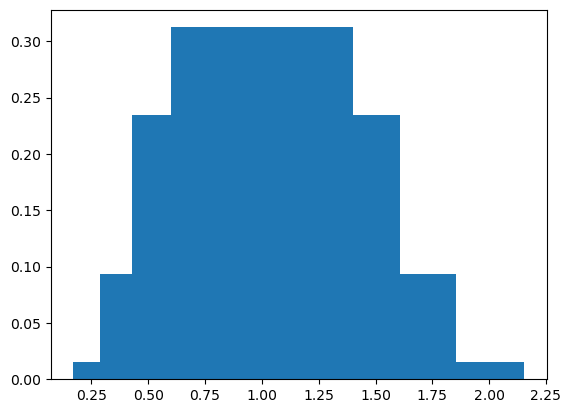

In [2]:
# discretize using a rowenhorst process
def rouwenhorst(rho, sigma, N):
    '''
    Takes a regression to mean, error standard deviation, and number of points
    and makes the rouwenhorst transition matrix for it
    '''
    # config
    sigma_process = np.sqrt(sigma**2 / (1 - rho**2))  # standard deviation of ar1 process
    pq = (1 + rho) / 2  # p = q
    psi = sigma_process * np.sqrt(N - 1)  # max/min gridpoint, finer grid that spreads out more as N increases
    grid = np.linspace(-psi, psi, N)  # to map to logs, the grid becomes exp(grid)

    # make matrix
    mat = np.array([
            [pq, 1-pq],
            [1-pq, pq],
        ])
    for _ in range(2, N):
        mat_l = mat
        mat = np.zeros((len(mat_l) + 1, len(mat_l) + 1))  # make matrix with 1 more dimension
        mat[:-1, :-1] += pq * mat_l  # top left
        mat[1:, :-1] += (1-pq) * mat_l  # bottom left
        mat[:-1, 1:] += (1-pq) * mat_l  # top right
        mat[1:, 1:] += pq * mat_l  # bottom right
        mat[:, 1:-1] /= 2  # sum to 1

    return mat, grid

# make grids
tran_mat_z, grid_z = rouwenhorst(RHO_z, SIGMA_z, N_z)
grid_z = np.exp(grid_z)  # process happens on log scale

# get distribution
vals, vecs = np.linalg.eig(tran_mat_z)
i = np.argmax(np.abs(vals))
assert np.isclose(vals[i], 1)  # markov process
dist_z = vecs[:, i]
dist_z /= sum(dist_z)  # normalize
agg_z = (grid_z * dist_z).sum()

# plot it
plt.bar(grid_z, dist_z)

#### Blocks
We'll use the aggregates that we have to get the different blocks. This assumes steady state, so there's no time funkiness.

Additionally, since it's the steady state, we know

\begin{align*}
    P_{ss}^A &= \frac{\psi}{\psi - 1} \frac{W_{ss} Y_{ss}}{Z_{ss} (1 - \theta R_{ss}^{-1} \pi_{ss}^\psi)} \\
    P_{ss}^B &= \frac{Y_{ss}}{1 - \theta R_{ss}^{-1} \pi_{ss}^\psi}
\end{align*}
which since prices are stable and $P_{ss}^A = P_{ss}^B$
$$
    W_{ss} = Z_{ss} \frac{\psi - 1}{\psi}
$$

In [3]:
@nb.njit
def ss_aggs(Y_ss, R_ss, Z_ss=Z_ss, xi_ss=xi_ss):
    '''
    Gets aggs in the steady state from the different blocks.

    Uses the fact that the variables don't change over time
    '''
    # steady state
    pi_ss = 1.  # ss def
    W_ss = Z_ss * (PSI - 1) / PSI  # constant

    # firm block
    N_ss = Y_ss / Z_ss
    D_ss = Y_ss - W_ss * N_ss

    # monetary block
    I_ss = R_ss * pi_ss**OMEGA * xi_ss

    # govt block
    tau_ss = (R_ss - 1) * B_BAR / agg_z

    # more ss
    PA_ss = PSI / (PSI - 1) * W_ss * Y_ss / (Z_ss * (1 - THETA * R_ss**(-1) * pi_ss**PSI))
    PB_ss = Y_ss / (1 - THETA * R_ss**(-1) * pi_ss**PSI)

    return W_ss, PA_ss, PB_ss, N_ss, tau_ss, I_ss, pi_ss, D_ss

#### EGM
To do the endogenous grid method, we now have to account for the labor-leisure choice on top of the normal intertemporal constraint. Therefore, instead of solving everything in terms of the savings function, we'll do the EGM in terms of the derivative of the value function
$$
    V_t(a_{i, t-1}, z_{i, t}) = \max_{c_{i, t}, \ell_{i, t}, a_{i, t}} \left[ \frac{c_{i, t}^{1-\gamma}}{1-\gamma} - \phi \frac{\ell_{i, t}^{1+\nu}}{1+\nu} + \beta \mathbb{E} V_{t+1} (a_{i, t}, z_{i, t+1}) \right]
$$
where
$$
    V_{t, a} (a_{i, t-1}, z_{i, t}) = R_t c_{i, t}^{-\gamma}.
$$

Therefore, we start the EGM assuming a level of savings (gridpoints) and a function for $V_{t+1, a}$ and solve backwards to get
1. Consumption this period. We know
$$
    c_{i, t} = \left(\beta \mathbb{E} R_{t+1} c_{i, t+1}^{-\gamma}\right)^\frac{-1}{\gamma} = \left(\beta \mathbb{E} V_{t+1, a}\right)^\frac{-1}{\gamma}
$$
2. Labor this period. We know
$$
    \ell_{i, t} = \left( \frac{W_t z_{i, t} c_{i, t}^{-\gamma}}{\phi} \right)^\frac{1}{\nu}
$$
3. Savings to start this period. We know
$$
    a_{i, t-1} = \frac{1}{R_t} \left(a_{i, t} + c_{i, t} - W_t z_{i, t} \ell_{i, t} - D_t + \tau_t z_{i, t} \right)
$$
4. Functional forms for all of these by interpolating.
5. Impose the budget constraint and recalculate consumption and labor where needed.
6. Create the array of this period $V_{t, a}$.

In [4]:
@nb.njit
def linear_interpolation(x, y, X):  # helper numberical methods function we need
    '''
    Performs a linear interpolation of x and y at X
    '''
    # setuo
    n = len(x)

    # create and return interpolation
    idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
    x_l = x[idx-1]  # values below the x
    y_l = y[idx-1]
    x_h = x[idx]  # values above the x
    y_h = y[idx]
    m = (y_h - y_l) / (x_h - x_l)  # slope
    return y_l + m * (X - x_l)  


@nb.njit
def func_interp(a_l_init, y_t_init, a_l_res=GRID):
    '''
    Finds the value of y_t at a_l_res given y_t maps to a_l_init
    '''
    # interpolate
    y_t_res = np.empty((a_l_res.shape[0], y_t_init.shape[1]))
    for i in nb.prange(N_z):
        y_t_res[:, i] = linear_interpolation(a_l_init[:, i], y_t_init[:, i], a_l_res)
    return y_t_res


@nb.njit
def labor_leisure_choice(c_0, Wz_t, T_t, maxiter=20, tol=1e-12):
    '''
    Solves for optimal labor and consumption given an initial guess for
    consumption, c_0, a vector of wages W_z, and net transfers T_t

    Essentially just uses newtons method
    '''
    # loop
    c = c_0

    # newtons method
    f = lambda c: c - Wz_t**(1 + 1/NU) * PHI**(-1/NU) * c**(-GAMMA / NU) - T_t
    df = lambda c: 1 + (GAMMA / NU) * Wz_t**(1 + 1/NU) * PHI**(-1/NU) * c**(-GAMMA / NU - 1)
    for _ in range(maxiter):
        # update rule (1d newton)
        dc = f(c) / df(c)
        c -= dc

        # exit condition
        if np.abs(dc).max() < tol:
            break
    else:
        print('Consumption Finding: Max iteration count exceeded')
    
    return c


@nb.njit
def euler_back(V_a_p, W_t, R_t, D_t, tau_t, grid_z=grid_z, tran_mat_z=tran_mat_z, grid=GRID[:, None]):
    '''
    Returns the value function deriivative and economic variables at the
    gridpoints this period
    '''
    # setup
    T_t = D_t - tau_t * grid_z  # net transfers
    Wz_t = W_t * grid_z

    # get consumption
    u_c_t = V_a_p @ (BETA * tran_mat_z)
    c_t = (u_c_t)**(-1 / GAMMA)  # get consumption (on next period grid)
    l_t = (Wz_t * u_c_t / PHI)**(1 / NU)  # labor (on next period grid)

    # option 1
    a_l = 1 / R_t * (grid + c_t - Wz_t * l_t - T_t)  # savings at start of period (based on next period grid)

    # get values on current grid
    c_t = func_interp(a_l, c_t, grid[:, 0])  # map to gridpoints now
    l_t = func_interp(a_l, l_t, grid[:, 0])

    # budget constraint
    a_t = R_t * grid + Wz_t * l_t + T_t - c_t  # option 1
    constr_i, constr_j = np.where(a_t < A_MIN)  # mask for where households are borrowing constrained
    if len(constr_i) > 0:
        c_constr = np.empty(len(constr_i))
        for i in nb.prange(len(constr_i)):
            c_constr[i] = c_t[constr_i[i], constr_j[i]]
        c_constr = labor_leisure_choice(c_constr, Wz_t[constr_j], R_t * grid[constr_i, 0] + T_t[constr_j] - A_MIN)
        l_constr = (A_MIN + c_constr - R_t * grid[constr_i, 0] - T_t[constr_j]) / Wz_t[constr_j]
        
        # put into arrays
        for i in nb.prange(len(constr_i)):
            a_t[constr_i[i], constr_j[i]] = A_MIN
            c_t[constr_i[i], constr_j[i]] = c_constr[i]
            l_t[constr_i[i], constr_j[i]] = l_constr[i]

    # value function derivative (to go backwards again)
    V_a_t = R_t * c_t**(-GAMMA)

    return V_a_t, a_t, c_t, l_t

#### Transition Matrix
Make the transition matrix between idiosyncratic states.

In [5]:
@nb.njit
def make_tran_mat_vectors(b_t, b_l=GRID, tran_mat_z=tran_mat_z):
    '''
    Makes the wealth distribution transition matrix givena savings rule
    from each of the gridpoints. Returns the data, row, and column matricies
    to make a sparse matrix for it, not the matrix itself
    '''
    # figure out where values go
    idxs = np.minimum(np.searchsorted(b_l, b_t, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = np.empty(b_t.shape)
    for i in nb.prange(idxs.shape[0]):
        for j in nb.prange(idxs.shape[1]):
            idx = idxs[i, j]
            p_l[i, j] = max((b_l[idx] - b_t[i, j]) / (b_l[idx] - b_l[idx-1]), 0.)
    # # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transision matricies
    # map capital now - > capital later
    data = np.vstack((p_l, p_h))  # each row resepsends a different level of capital
    row = np.vstack((idxs-1, idxs))
    col = np.hstack((np.arange(N_A), np.arange(N_A)))[:, None] + np.zeros((1, N_z))

    # add exogenous probability shocks
    data = (data[:, :, None] * tran_mat_z.T[None, :, :]).ravel()
    row = (row[:, :, None] + N_A * np.arange(N_z)).ravel()
    col = (col[:, None, :] + N_A * np.arange(N_z)[None, :, None]).ravel()
    
    return data, row, col


def make_tran_mat(b_t):
    '''
    Makes the transition matrix for idiosyncratic shocks and wealth levels for
    households
    '''
    data, row, col = make_tran_mat_vectors(b_t)
    tran_mat = sparse.csr_array((data, (row, col)), shape=(N_A * N_z, N_A * N_z))  # sparse array cant be jit compiled

    return tran_mat

#### Aggregators
We'll aggregate labor and bond holdings to try to get demand for bonds and supply of labor. These are what we check with the market clearing condition.

In [6]:
@nb.njit
def agg_L(l_t, dist_t, grid_z=grid_z):
    return (dist_t * l_t * grid_z).sum()


@nb.njit
def agg_B(dist_t, grid=GRID):
    return (dist_t.T * grid).sum()

#### Steady State
To find the steady state for the economy, we'll use the EGM aggregates in the steady state to get both markets to clear.

In [7]:
@nb.njit
def egm(V_a_t, W_t, R_t, D_t, tau_t, grid_z=grid_z, tran_mat_z=tran_mat_z, grid=GRID[:, None], max_iter=10000, tol=1e-14):
    for _ in range(max_iter):
        # get new consumption function
        (V_a_t, a_t, c_t, l_t), last_V_a_t = euler_back(V_a_t, W_t, R_t, D_t, tau_t, grid_z=grid_z, tran_mat_z=tran_mat_z, grid=grid), V_a_t

        # exit condition
        diff = np.abs(V_a_t - last_V_a_t).max()
        if diff < tol:
            break
    else:
        print('Policy Rule: Max iteration count exceeded')
    
    return V_a_t, a_t, c_t, l_t


def get_dist(a_t):
    '''
    Use the eignevector of a sparse matrix to find the stationary distribution
    of capital
    '''
    # get transition matrix
    tran_mat = make_tran_mat(a_t)

    # use eigenvalues to get the steady state distribution of capital
    dist = sparse.linalg.eigs(tran_mat, k=1)[1].real  # get dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, N_z), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    return dist, tran_mat


V_a_ss0 = (GRID[:, None] * (1 / BETA - 1) + grid_z)**(-GAMMA)  # initial guess for the value function
def sim_ss(Y_ss, R_ss, V_a_ss0=V_a_ss0):
    W_ss, PA_ss, PB_ss, N_ss, tau_ss, I_ss, pi_ss, D_ss = ss_aggs(Y_ss, R_ss)
    V_a_ss, a_ss, c_ss, l_ss = egm(V_a_ss0, W_ss, R_ss, D_ss, tau_ss)  # use the egm to solve for a policy rule
    a_ss[a_ss < 0.] = 0.
    V_a_ss0[:] = V_a_ss  # make next iteration faster
    dist_ss, tran_mat_ss = get_dist(a_ss)  # get the distribution of capital
    L_ss = agg_L(l_ss, dist_ss)
    B_ss = agg_B(dist_ss)

    return L_ss, B_ss, W_ss, PA_ss, PB_ss, N_ss, tau_ss, R_ss, I_ss, pi_ss, D_ss, V_a_ss, a_ss, c_ss, l_ss, dist_ss, tran_mat_ss

# break to keep jits compiled

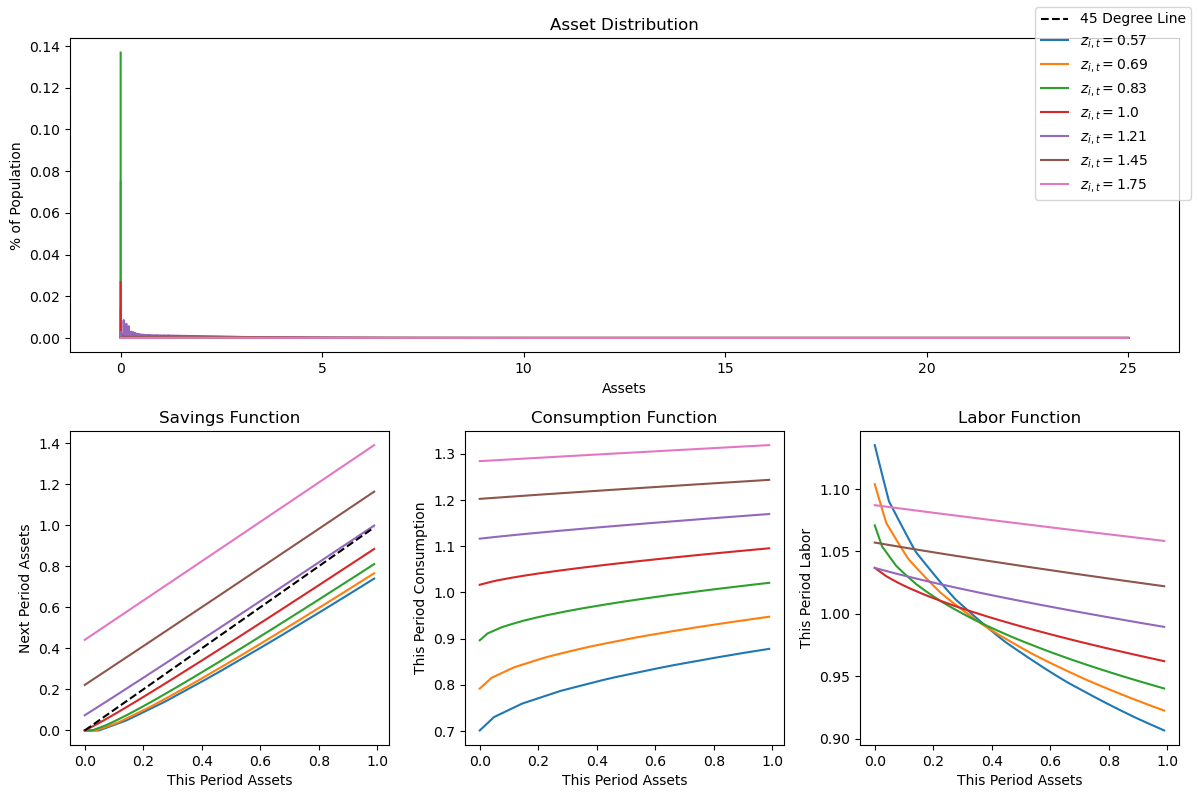

In [8]:
# params
Y0 = ((PSI - 1) / (PSI * PHI))**(1 / (NU + GAMMA))  # intiial guess
R0 = 1 / BETA
ss_tol = 1e-12  # tolerance

# find steady state
def check_ss(seed):
    L_ss, B_ss, _, _, _, N_ss, _, _, _, _, _, _, _, _, _, _, _ = sim_ss(*seed)
    return np.array([L_ss - N_ss, B_ss - B_BAR])
res = root(check_ss, np.array([Y0, R0]), tol=ss_tol)
assert res.success
Y_ss, R_ss = res.x

# get other steady state values
L_ss, B_ss, W_ss, PA_ss, PB_ss, N_ss, tau_ss, R_ss, I_ss, pi_ss, D_ss, V_a_ss, a_ss, c_ss, l_ss, dist_ss, tran_mat_ss = sim_ss(Y_ss, R_ss)
assert np.isclose((c_ss * dist_ss).sum(), Y_ss)  # sanity check walras

# setup plot
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Asset Distribution')
axtop.set_xlabel('Assets')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')
axs[1, 2].set_title('Labor Function')
axs[1, 2].set_xlabel('This Period Assets')
axs[1, 2].set_ylabel('This Period Labor')

# plot it
axtop.plot(GRID, dist_ss, label=['$z_{i, t}='+str(round(z, 2))+'$' for z in grid_z])
n = (GRID <= 1).sum()  # look at first n gridpoits, most the interesting stuff happens early
axs[1, 0].plot(GRID[:n], a_ss[:n])
axs[1, 0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], c_ss[:n])
axs[1, 2].plot(GRID[:n], l_ss[:n])

# final things
fig.legend()
fig.tight_layout()

#### Sequence Space Jacobian
To solve for an IRF of the model, we'll use the SSJ method. We'll again create a function
$$
    F(\mathbf{X}, \mathbf{Z}) = \vec 0
$$
where
$$
    \mathbf{X} = \begin{pmatrix}
        \vec P^A \\ \vec P^B \\ \vec Y \\ \vec W
    \end{pmatrix} = \begin{pmatrix}
        P_1^A \\ \vdots \\ P_T^A \\ P_1^B \\ \vdots \\ P_T^B \\ Y_1 \\ \vdots \\ Y_T \\ W_1 \\ \vdots \\ W_T 
    \end{pmatrix}, \quad \mathbf{Z} = \begin{pmatrix}
        \vec Z \\ \vec \xi
    \end{pmatrix} = \begin{pmatrix}
        Z_1 \\ \vdots \\ Z_T \\ \xi_1 \\ \vdots \\ \xi_T
    \end{pmatrix}, \quad F = \begin{pmatrix}
        F_1 (\mathbf{X}, \mathbf{Z}) \\ F_2 (\mathbf{X}, \mathbf{Z}) \\ F_3 (\mathbf{X}, \mathbf{Z}) \\ F_4 (\mathbf{X}, \mathbf{Z})
    \end{pmatrix} = \begin{pmatrix}
        N_1 - L_1 \\ \vdots \\ N_T - L_T \\ B_1 - B \\ \vdots \\ B_T - B \\ \frac{\psi}{\psi-1} \frac{W_1}{Z_1} Y_1 + \theta R_2^{-1} \pi_2^\psi P_2^A - P_1^A \\ \vdots \\ \frac{\psi}{\psi-1} \frac{W_T}{Z_T} Y_T + \theta R_{T+1}^{-1} \pi_{T+1}^\psi P_{T+1}^A - P_T^A \\ Y_1 + \theta R_2^{-1} \pi_2^{\psi-1} P_2^B - P_1^B \\ \vdots \\ Y_T + \theta R_{T+1}^{-1} \pi_{T+1}^{\psi-1} P_{T+1}^B - P_T^B
    \end{pmatrix}.
$$

To create the Jacobian that we use to solve the model, we'll create
$$
    F_\mathbf{X} = \begin{pmatrix}
        F_{1 \vec P^A} & F_{1 \vec P^B} & F_{1 \vec Y} & F_{1 \vec W} \\
        F_{2 \vec P^A} & F_{2 \vec P^B} & F_{2 \vec Y} & F_{2 \vec W} \\
        F_{3 \vec P^A} & F_{3 \vec P^B} & F_{3 \vec Y} & F_{3 \vec W} \\
        F_{4 \vec P^A} & F_{4 \vec P^B} & F_{4 \vec Y} & F_{4 \vec W} \\
    \end{pmatrix}, \quad F_\mathbf{Z} = \begin{pmatrix}
        F_{1 \vec Z} & F_{1 \vec \xi} \\
        F_{2 \vec Z} & F_{2 \vec \xi} \\
        F_{3 \vec Z} & F_{3 \vec \xi} \\
        F_{4 \vec Z} & F_{4 \vec \xi} \\
    \end{pmatrix}.
$$

The blocks for $F_1$ and $F_2$ we'll create using the Fake News algorithm and the blocks for $F_3$ and $F_4$ we'll solve for analytically.

In [9]:
# shock params
T = 300
Z_ss = 1.
xi_ss = 1.

# shock path
dZ_path = SIGMA_Z * np.full(T, RHO_Z) ** np.arange(T)  # linearized (no exp)
dxi_path = SIGMA_xi * np.full(T, RHO_xi) ** np.arange(T)

#### Derivatives
Analytically, we need to find a few derivatives to implement the algorithm. To make the fake news matrix, we need the derivatives of everything determined within the model ($\pi_t$, $W_t$, $I_t$, $R_t$, $D_t$, $\tau_t$) with respect to the inputs. We get

\begin{align*}
    \frac{\partial \pi_t}{\partial P_t^A} &= \frac{1 - \theta}{\theta P_t^B} \left(\frac{P_t^A}{P_t^B}\right)^{-\psi} \left(\frac{1 - (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi}}{\theta}\right)^\frac{2-\psi}{\psi-1} \\
    \frac{\partial \pi_t}{\partial P_t^B} &= - \frac{(1 - \theta) P_t^A}{\theta P_t^{B 2}} \left(\frac{P_t^A}{P_t^B}\right)^{-\psi} \left(\frac{1 - (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi}}{\theta}\right)^\frac{2-\psi}{\psi-1} \\
    \frac{\partial N_t}{\partial Y_t} &= \frac{1}{Z_t} \\
    \frac{\partial N_t}{\partial Z_t} &= -\frac{Y_t}{Z_t^2} \\
    \frac{\partial D_t}{\partial Y_t} &= 1 - W_t \frac{\partial N_t}{\partial Y_t} \\
    \frac{\partial D_t}{\partial W_t} &= - N_t \\
    \frac{\partial D_t}{\partial Z_t} &= - W_t \frac{\partial N_t}{\partial Z_t} \\
    \frac{\partial I_t}{\partial P_t^A} &= \omega R_{ss} \pi_t^{\omega - 1} \xi_t \frac{\partial \pi_t}{\partial P_t^A} \\
    \frac{\partial I_t}{\partial P_t^B} &= \omega R_{ss} \pi_t^{\omega - 1} \xi_t \frac{\partial \pi_t}{\partial P_t^B} \\
    \frac{\partial I_t}{\partial \xi_t} &= R_{ss} \pi_t^\omega \\
    \frac{\partial R_t}{\partial P_{t-1}^A} &= \frac{1}{\pi_t} \frac{\partial I_{t-1}}{\partial P_{t-1}^A} \\
    \frac{\partial R_t}{\partial P_{t-1}^B} &= \frac{1}{\pi_t} \frac{\partial I_{t-1}}{\partial P_{t-1}^B} \\
    \frac{\partial R_t}{\partial \xi_{t-1}} &= \frac{1}{\pi_t} \frac{\partial I_{t-1}}{\partial \xi_{t-1}} \\
    \frac{\partial R_t}{\partial P_t^A} &= -\frac{I_{t-1}}{\pi_t^2} \frac{\partial \pi_t}{\partial P_t^A} \\
    \frac{\partial R_t}{\partial P_t^B} &= -\frac{I_{t-1}}{\pi_t^2} \frac{\partial \pi_t}{\partial P_t^B} \\
    \frac{\partial \tau_t}{\partial P_{t-1}^A} &= \frac{B}{\int_0^1 z_{i, t} di} \frac{\partial R_t}{\partial P_{t-1}^A} \\
    \frac{\partial \tau_t}{\partial P_{t-1}^B} &= \frac{B}{\int_0^1 z_{i, t} di} \frac{\partial R_t}{\partial P_{t-1}^B} \\
    \frac{\partial \tau_t}{\partial xi_{t-1}} &= \frac{B}{\int_0^1 z_{i, t} di} \frac{\partial R_t}{\partial \xi_{t-1}} \\
    \frac{\partial \tau_t}{\partial P_t^A} &= \frac{B}{\int_0^1 z_{i, t} di} \frac{\partial R_t}{\partial P_t^A} \\
    \frac{\partial \tau_t}{\partial P_t^B} &= \frac{B}{\int_0^1 z_{i, t} di} \frac{\partial R_t}{\partial P_t^B}
\end{align*}

Using these equations, we'll differentiate around the steady state and then construct the Jacobian to be able to solve the IRF.

In [10]:
# ## Check my Work (Comment out when actually doing anything)
# import jax  # autodiff library
# check_vals = np.linspace(1, 10, 3)  # arbitrary

# # pi
# pi = lambda PA_t, PB_t: ((1 - (1 - THETA) * (PA_t / PB_t)**(1-PSI)) / THETA)**(1 / (PSI-1))

# dpi_t_dPA_t = lambda PA_t, PB_t: (1 - THETA) / (THETA * PB_t) * (PA_t / PB_t)**(-PSI) * ((1 - (1 - THETA) * (PA_t / PB_t)**(1-PSI)) / THETA)**((2 - PSI) / (PSI-1))
# jax_dpi_t_dPA_t = jax.grad(pi, 0)
# dpi_t_dPB_t = lambda PA_t, PB_t: - (1 - THETA) * PA_t / (THETA * PB_t**2) * (PA_t / PB_t)**(-PSI) * ((1 - (1 - THETA) * (PA_t / PB_t)**(1-PSI)) / THETA)**((2 - PSI) / (PSI-1))
# jax_dpi_t_dPB_t = jax.grad(pi, 1)

# for PA_t in check_vals:
#     for PB_t in check_vals:
#         if PB_t > PA_t: continue  # nans
#         assert np.isclose(dpi_t_dPA_t(PA_t, PB_t), jax_dpi_t_dPA_t(PA_t, PB_t))
#         assert np.isclose(dpi_t_dPB_t(PA_t, PB_t), jax_dpi_t_dPB_t(PA_t, PB_t))

# # N
# N = lambda Y_t, Z_t: Y_t / Z_t

# dN_t_dY_t = lambda Y_t, Z_t: 1 / Z_t
# jax_dN_t_dY_t = jax.grad(N, 0)
# dN_t_dZ_t = lambda Y_t, Z_t: -Y_t / Z_t**2
# jax_dN_t_dZ_t = jax.grad(N, 1)

# for Y_t in check_vals:
#     for Z_t in check_vals:
#         assert np.isclose(dN_t_dY_t(Y_t, Z_t), jax_dN_t_dY_t(Y_t, Z_t))
#         assert np.isclose(dN_t_dZ_t(Y_t, Z_t), jax_dN_t_dZ_t(Y_t, Z_t))

# # D
# D = lambda Y_t, W_t, Z_t: Y_t - W_t * N(Y_t, Z_t)

# dD_t_dY_t = lambda Y_t, W_t, Z_t: 1 - W_t * dN_t_dY_t(Y_t, Z_t)
# jax_dD_t_dY_t = jax.grad(D, 0)
# dD_t_dW_t = lambda Y_t, W_t, Z_t: -N(Y_t, Z_t)
# jax_dD_t_dW_t = jax.grad(D, 1)
# dD_t_dZ_t = lambda Y_t, W_t, Z_t: -W_t * dN_t_dZ_t(Y_t, Z_t)
# jax_dD_t_dZ_t = jax.grad(D, 2)

# for Y_t in check_vals:
#     for W_t in check_vals:
#         for Z_t in check_vals:
#             assert np.isclose(dD_t_dY_t(Y_t, W_t, Z_t), jax_dD_t_dY_t(Y_t, W_t, Z_t))
#             assert np.isclose(dD_t_dW_t(Y_t, W_t, Z_t), jax_dD_t_dW_t(Y_t, W_t, Z_t))
#             assert np.isclose(dD_t_dZ_t(Y_t, W_t, Z_t), jax_dD_t_dZ_t(Y_t, W_t, Z_t))

# # I
# I = lambda PA_t, PB_t, xi_t: R_ss * pi(PA_t, PB_t)**OMEGA * xi_t

# dI_t_dPA_t = lambda PA_t, PB_t, xi_t: OMEGA * R_ss * pi(PA_t, PB_t)**(OMEGA - 1) * xi_t * dpi_t_dPA_t(PA_t, PB_t)
# jax_dI_t_dPA_t = jax.grad(I, 0)
# dI_t_dPB_t = lambda PA_t, PB_t, xi_t: OMEGA * R_ss * pi(PA_t, PB_t)**(OMEGA - 1) * xi_t * dpi_t_dPB_t(PA_t, PB_t)
# jax_dI_t_dPB_t = jax.grad(I, 1)
# dI_t_dxi_t = lambda PA_t, PB_t, xi_t: R_ss * pi(PA_t, PB_t)**OMEGA
# jax_dI_t_dxi_t = jax.grad(I, 2)

# for PA_t in check_vals:
#     for PB_t in check_vals:
#         if PB_t > PA_t: continue  # nans
#         for xi_t in check_vals:
#             assert np.isclose(dI_t_dPA_t(PA_t, PB_t, xi_t), jax_dI_t_dPA_t(PA_t, PB_t, xi_t))
#             assert np.isclose(dI_t_dPB_t(PA_t, PB_t, xi_t), jax_dI_t_dPB_t(PA_t, PB_t, xi_t))
#             assert np.isclose(dI_t_dxi_t(PA_t, PB_t, xi_t), jax_dI_t_dxi_t(PA_t, PB_t, xi_t))

# # R
# R = lambda PA_l, PB_l, xi_l, PA_t, PB_t: I(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)

# dR_t_dPA_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: dI_t_dPA_t(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)
# jax_dR_t_dPA_l = jax.grad(R, 0)
# dR_t_dPB_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: dI_t_dPB_t(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)
# jax_dR_t_dPB_l = jax.grad(R, 1)
# dR_t_dxi_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: dI_t_dxi_t(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)
# jax_dR_t_dxi_l = jax.grad(R, 2)
# dR_t_dPA_t = lambda PA_l, PB_l, xi_l, PA_t, PB_t: -I(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)**2 * dpi_t_dPA_t(PA_t, PB_t)
# jax_dR_t_dPA_t = jax.grad(R, 3)
# dR_t_dPB_t = lambda PA_l, PB_l, xi_l, PA_t, PB_t: -I(PA_l, PB_l, xi_l) / pi(PA_t, PB_t)**2 * dpi_t_dPB_t(PA_t, PB_t)
# jax_dR_t_dPB_t = jax.grad(R, 4)

# for PA_l in check_vals:
#     for PB_l in check_vals:
#         if PB_l > PA_l: continue  # nans
#         for xi_l in check_vals:
#             for PA_t in check_vals:
#                 for PB_t in check_vals:
#                     if PB_t > PA_t: continue  # nans
#                     assert np.isclose(dR_t_dPA_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dR_t_dPA_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dR_t_dPB_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dR_t_dPB_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dR_t_dxi_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dR_t_dxi_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dR_t_dPA_t(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dR_t_dPA_t(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dR_t_dPB_t(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dR_t_dPB_t(PA_l, PB_l, xi_l, PA_t, PB_t))

# # tau
# tau = lambda PA_l, PB_l, xi_l, PA_t, PB_t: (R(PA_l, PB_l, xi_l, PA_t, PB_t) - 1) * B_BAR / agg_z

# dtau_t_dPA_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: B_BAR / agg_z * dR_t_dPA_l(PA_l, PB_l, xi_l, PA_t, PB_t)
# jax_dtau_t_dPA_l = jax.grad(tau, 0)
# dtau_t_dPB_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: B_BAR / agg_z * dR_t_dPB_l(PA_l, PB_l, xi_l, PA_t, PB_t)
# jax_dtau_t_dPB_l = jax.grad(tau, 1)
# dtau_t_dxi_l = lambda PA_l, PB_l, xi_l, PA_t, PB_t: B_BAR / agg_z * dR_t_dxi_l(PA_l, PB_l, xi_l, PA_t, PB_t)
# jax_dtau_t_dxi_l = jax.grad(tau, 2)
# dtau_t_dPA_t = lambda PA_l, PB_l, xi_l, PA_t, PB_t: B_BAR / agg_z * dR_t_dPA_t(PA_l, PB_l, xi_l, PA_t, PB_t)
# jax_dtau_t_dPA_t = jax.grad(tau, 3)
# dtau_t_dPB_t = lambda PA_l, PB_l, xi_l, PA_t, PB_t: B_BAR / agg_z * dR_t_dPB_t(PA_l, PB_l, xi_l, PA_t, PB_t)
# jax_dtau_t_dPB_t = jax.grad(tau, 4)

# for PA_l in check_vals:
#     for PB_l in check_vals:
#         if PB_l > PA_l: continue  # nans
#         for xi_l in check_vals:
#             for PA_t in check_vals:
#                 for PB_t in check_vals:
#                     if PB_t > PA_t: continue  # nans
#                     assert np.isclose(dtau_t_dPA_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dtau_t_dPA_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dtau_t_dPB_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dtau_t_dPB_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dtau_t_dxi_l(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dtau_t_dxi_l(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dtau_t_dPA_t(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dtau_t_dPA_t(PA_l, PB_l, xi_l, PA_t, PB_t))
#                     assert np.isclose(dtau_t_dPB_t(PA_l, PB_l, xi_l, PA_t, PB_t), jax_dtau_t_dPB_t(PA_l, PB_l, xi_l, PA_t, PB_t))

# # f3
# f3 = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: PSI / (PSI - 1) * W_t / Z_t * Y_t + THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**PSI * PA_p - PA_t

# df3_t_dY_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: PSI / (PSI - 1) * W_t / Z_t
# jax_df3_t_dY_t = jax.grad(f3, 0)
# df3_t_dW_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: PSI / (PSI - 1) * Y_t / Z_t
# jax_df3_t_dW_t = jax.grad(f3, 1)
# df3_t_dZ_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -PSI / (PSI - 1) * W_t * Y_t / Z_t**2
# jax_df3_t_dZ_t = jax.grad(f3, 2)
# df3_t_dPA_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**PSI * PA_p * dR_t_dPA_l(PA_t, PB_t, xi_t, PA_p, PB_p) - 1
# jax_df3_t_dPA_t = jax.grad(f3, 3)
# df3_t_dPB_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**PSI * PA_p * dR_t_dPB_l(PA_t, PB_t, xi_t, PA_p, PB_p)
# jax_df3_t_dPB_t = jax.grad(f3, 4)
# df3_t_dxi_t = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**PSI * PA_p * dR_t_dxi_l(PA_t, PB_t, xi_t, PA_p, PB_p)
# jax_df3_t_dxi_t = jax.grad(f3, 5)
# df3_t_dPA_p = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**PSI * PA_p * dR_t_dPA_t(PA_t, PB_t, xi_t, PA_p, PB_p) + PSI * THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 1) * PA_p * dpi_t_dPA_t(PA_p, PB_p) + THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**PSI
# jax_df3_t_dPA_p = jax.grad(f3, 6)
# df3_t_dPB_p = lambda Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**PSI * PA_p * dR_t_dPB_t(PA_t, PB_t, xi_t, PA_p, PB_p) + PSI * THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 1) * PA_p * dpi_t_dPB_t(PA_p, PB_p)
# jax_df3_t_dPB_p = jax.grad(f3, 7)

# for Y_t in check_vals:
#     for W_t in check_vals:
#         for Z_t in check_vals:
#             for PA_t in check_vals:
#                 for PB_t in check_vals:
#                     if PB_t > PA_t: continue  # nans
#                     for xi_t in check_vals:
#                         for PA_p in check_vals:
#                             for PB_p in check_vals:
#                                 if PB_p > PA_p: continue  # nans
#                                 assert np.isclose(df3_t_dY_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dY_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dW_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dW_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dZ_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dZ_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dPA_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dPA_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dPB_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dPB_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dxi_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dxi_t(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dPA_p(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dPA_p(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                                 assert np.isclose(df3_t_dPB_p(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df3_t_dPB_p(Y_t, W_t, Z_t, PA_t, PB_t, xi_t, PA_p, PB_p))

# # f4
# f4 = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: Y_t + THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 1) * PB_p - PB_t

# df4_t_dY_t = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: 1
# jax_df4_t_dY_t = jax.grad(f4, 0)
# df4_t_dPA_t = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**(PSI - 1) * PB_p * dR_t_dPA_l(PA_t, PB_t, xi_t, PA_p, PB_p)
# jax_df4_t_dPA_t = jax.grad(f4, 1)
# df4_t_dPB_t = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**(PSI - 1) * PB_p * dR_t_dPB_l(PA_t, PB_t, xi_t, PA_p, PB_p) - 1
# jax_df4_t_dPB_t = jax.grad(f4, 2)
# df4_t_dxi_t = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**(PSI - 1) * PB_p * dR_t_dxi_l(PA_t, PB_t, xi_t, PA_p, PB_p)
# jax_df4_t_dxi_t = jax.grad(f4, 3)
# df4_t_dPA_p = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**(PSI - 1) * PB_p * dR_t_dPA_t(PA_t, PB_t, xi_t, PA_p, PB_p) + (PSI - 1) * THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 2) * PB_p * dpi_t_dPA_t(PA_p, PB_p)
# jax_df4_t_dPA_p = jax.grad(f4, 4)
# df4_t_dPB_p = lambda Y_t, PA_t, PB_t, xi_t, PA_p, PB_p: -THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-2) * pi(PA_p, PB_p)**(PSI - 1) * PB_p * dR_t_dPB_t(PA_t, PB_t, xi_t, PA_p, PB_p) + (PSI - 1) * THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 2) * PB_p * dpi_t_dPB_t(PA_p, PB_p) + THETA * R(PA_t, PB_t, xi_t, PA_p, PB_p)**(-1) * pi(PA_p, PB_p)**(PSI - 1)
# jax_df4_t_dPB_p = jax.grad(f4, 5)

# for Y_t in check_vals:
#     for PA_t in check_vals:
#         for PB_t in check_vals:
#             if PB_t > PA_t: continue  # nans
#             for xi_t in check_vals:
#                 for PA_p in check_vals:
#                     for PB_p in check_vals:
#                         if PB_p > PA_p: continue  # nans
#                         assert np.isclose(df4_t_dY_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dY_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                         assert np.isclose(df4_t_dPA_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dPA_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                         assert np.isclose(df4_t_dPB_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dPB_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                         assert np.isclose(df4_t_dxi_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dxi_t(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                         assert np.isclose(df4_t_dPA_p(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dPA_p(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))
#                         assert np.isclose(df4_t_dPB_p(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p), jax_df4_t_dPB_p(Y_t, PA_t, PB_t, xi_t, PA_p, PB_p))

In [11]:
@nb.njit
def d_pi(PA_t=PA_ss, PB_t=PB_ss):
    t = (PA_t / PB_t)**(-PSI) * ((1 - (1 - THETA) * (PA_t / PB_t)**(1-PSI)) / THETA)**((2 - PSI) / (PSI-1))
    dpi_dPA_t = (1 - THETA) / (THETA * PB_t) * t
    dpi_dPB_t = -(1 - THETA) * PA_t / (THETA * PB_t**2) * t

    return dpi_dPA_t, dpi_dPB_t


@nb.njit
def d_N(Y_t=Y_ss, Z_t=Z_ss):
    dN_dY_t = 1 / Z_t
    dN_dZ_t = -Y_t / Z_t**2

    return dN_dY_t, dN_dZ_t


@nb.njit
def d_D(dN_dY_t, dN_dZ_t, N_t=N_ss, W_t=W_ss):
    dD_dY_t = 1 - W_t * dN_dY_t
    dD_dW_t = -N_t
    dD_dZ_t = -W_t * dN_dZ_t

    return dD_dY_t, dD_dW_t, dD_dZ_t


@nb.njit
def d_I(dpi_dPA_t, dpi_dPB_t, pi_t=pi_ss, xi_t=xi_ss, R_ss=R_ss):
    t = OMEGA * R_ss * pi_t**(OMEGA - 1) * xi_t
    dI_dPA_t = t * dpi_dPA_t
    dI_dPB_t = t * dpi_dPB_t
    dI_dxi_t = R_ss * pi_ss**OMEGA

    return dI_dPA_t, dI_dPB_t, dI_dxi_t


@nb.njit
def d_R(dI_dPA_t, dI_dPB_t, dI_dxi_t, dpi_dPA_t, dpi_dPB_t, pi_t=pi_ss, I_l=I_ss):
    t1 = 1 / pi_ss
    dR_dPA_l = t1 * dI_dPA_t
    dR_dPB_l = t1 * dI_dPB_t
    dR_dxi_l = t1 * dI_dxi_t

    t2 = -I_l / pi_t**2
    dR_dPA_t = t2 * dpi_dPA_t
    dR_dPB_t = t2 * dpi_dPB_t

    return dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t


@nb.njit
def d_tau(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t):
    t = B_BAR / agg_z
    dtau_dPA_l = t * dR_dPA_l
    dtau_dPB_l = t * dR_dPB_l
    dtau_dxi_l = t * dR_dxi_l
    dtau_dPA_t = t * dR_dPA_t
    dtau_dPB_t = t * dR_dPB_t

    return dtau_dPA_l, dtau_dPB_l, dtau_dxi_l, dtau_dPA_t, dtau_dPB_t

# break to keep njits compiled

In [12]:
dpi_dPA_t, dpi_dPB_t = d_pi()
dN_dY_t, dN_dZ_t = d_N()
dD_dY_t, dD_dW_t, dD_dZ_t = d_D(dN_dY_t, dN_dZ_t)
dI_dPA_t, dI_dPB_t, dI_dxi_t = d_I(dpi_dPA_t, dpi_dPB_t)
dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t = d_R(dI_dPA_t, dI_dPB_t, dI_dxi_t, dpi_dPA_t, dpi_dPB_t)
dtau_dPA_l, dtau_dPB_l, dtau_dxi_l, dtau_dPA_t, dtau_dPB_t = d_tau(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t)

#### Bottom Blocks
Then, we also will analytically find the bottom two blocks of each column in the Jacobian matrix ($f_{3, t}$, $f_{4, t}$). We know

\begin{align*}
    \frac{\partial f_{3, t}}{\partial Y_t} &= \frac{\psi}{\psi - 1} \frac{W_t}{Z_t} \\
    \frac{\partial f_{3, t}}{\partial W_t} &= \frac{\psi}{\psi - 1} \frac{Y_t}{Z_t} \\
    \frac{\partial f_{3, t}}{\partial Z_t} &= - \frac{\psi}{\psi - 1} \frac{W_t Y_t}{Z_t^2} \\
    \frac{\partial f_{3, t}}{\partial P_t^A} &= -\theta R_{t+1}^{-2} \pi_{t+1}^\psi P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_t^A} - 1 \\
    \frac{\partial f_{3, t}}{\partial P_t^B} &= -\theta R_{t+1}^{-2} \pi_{t+1}^\psi P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_t^B} \\
    \frac{\partial f_{3, t}}{\partial \xi_t} &= -\theta R_{t+1}^{-2} \pi_{t+1}^\psi P_{t+1}^A \frac{\partial R_{t+1}}{\partial \xi_t} \\
    \frac{\partial f_{3, t}}{\partial P_{t+1}^A} &= -\theta R_{t+1}^{-2} \pi_{t+1}^\psi P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_{t+1}^A} + \psi \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^A \frac{\partial \pi_{t+1}}{\partial P_{t+1}^A} + \theta R_{t+1}^{-1} \pi_{t+1}^\psi \\
    \frac{\partial f_{3, t}}{\partial P_{t+1}^B} &= -\theta R_{t+1}^{-2} \pi_{t+1}^\psi P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_{t+1}^B} + \psi \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^A \frac{\partial \pi_{t+1}}{\partial P_{t+1}^B}\\
    \frac{\partial f_{4, t}}{\partial Y_t} &= 1 \\
    \frac{\partial f_{4, t}}{\partial P_t^A} &= -\theta R_{t+1}^{-2} \pi_{t+1}^{\psi - 1} P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_t^A} \\
    \frac{\partial f_{4, t}}{\partial P_t^B} &= -\theta R_{t+1}^{-2} \pi_{t+1}^{\psi - 1} P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_t^B} - 1 \\
    \frac{\partial f_{4, t}}{\partial \xi_t} &= -\theta R_{t+1}^{-2} \pi_{t+1}^{\psi - 1} P_{t+1}^A \frac{\partial R_{t+1}}{\partial \xi_t} \\
    \frac{\partial f_{4, t}}{\partial P_{t+1}^A} &= -\theta R_{t+1}^{-2} \pi_{t+1}^{\psi - 1} P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_{t+1}^A} + (\psi-1) \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-2} P_{t+1}^B \frac{\partial \pi_{t+1}}{\partial P_{t+1}^A} \\
    \frac{\partial f_{4, t}}{\partial P_{t+1}^B} &= -\theta R_{t+1}^{-2} \pi_{t+1}^{\psi - 1} P_{t+1}^A \frac{\partial R_{t+1}}{\partial P_{t+1}^B} + (\psi-1) \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-2} P_{t+1}^B \frac{\partial \pi_{t+1}}{\partial P_{t+1}^B} + \theta R_{t+1}^{-1} \pi_{t+1}^{\psi - 1} \\
\end{align*}

Then, the Jacobians for the functions $(F_n)_X$ is
$$
    (F_n)_X = \begin{pmatrix}
        \frac{\partial f_{n, 1}}{\partial x_1} & \frac{\partial f_{n, 1}}{\partial x_2} & \frac{\partial f_{n, 1}}{\partial x_3} & \dots \\
        \frac{\partial f_{n, 2}}{\partial x_1} & \frac{\partial f_{n, 2}}{\partial x_2} & \frac{\partial f_{n, 2}}{\partial x_3} & \dots \\
        \frac{\partial f_{n, 3}}{\partial x_1} & \frac{\partial f_{n, 3}}{\partial x_2} & \frac{\partial f_{n, 3}}{\partial x_3} & \dots \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} = \begin{pmatrix}
        \frac{\partial f_{n, t}}{\partial x_t} & \frac{\partial f_{n, t}}{\partial x_{t+1}} & \frac{\partial f_{n, t}}{\partial x_{t+2}} & \dots \\
        \frac{\partial f_{n, t}}{\partial x_{t-1}} & \frac{\partial f_{n, t}}{\partial x_t} & \frac{\partial f_{n, t}}{\partial x_{t+1}} & \dots \\
        \frac{\partial f_{n, t}}{\partial x_{t-2}} & \frac{\partial f_{n, t}}{\partial x_{t-1}} & \frac{\partial f_{n, t}}{\partial x_t} & \dots \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix}
$$
which means

\begin{align*}
    (F_3)_Y &= \begin{pmatrix}
        \frac{\partial f_{3, t}}{\partial Y_t} & 0 & 0 & \dots \\
        0 & \frac{\partial f_{3, t}}{\partial Y_t} & 0 & \dots \\
        0 & 0 & \frac{\partial f_{3, t}}{\partial Y_t} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_3)_W &= \begin{pmatrix}
        \frac{\partial f_{3, t}}{\partial W_t} & 0 & 0 & \dots \\
        0 & \frac{\partial f_{3, t}}{\partial W_t} & 0 & \dots \\
        0 & 0 & \frac{\partial f_{3, t}}{\partial W_t} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_3)_{P^A} &= \begin{pmatrix}
        \frac{\partial f_{3, t}}{\partial P_t^A} & \frac{\partial f_{3, t}}{\partial P_{t+1}^A} & 0 & \dots \\
        0 & \frac{\partial f_{3, t}}{\partial P_t^A} & \frac{\partial f_{3, t}}{\partial P_{t+1}^A} & \dots \\
        0 & 0 & \frac{\partial f_{3, t}}{\partial P_t^A} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_3)_{P^B} &= \begin{pmatrix}
        \frac{\partial f_{3, t}}{\partial P_t^B} & \frac{\partial f_{3, t}}{\partial P_{t+1}^B} & 0 & \dots \\
        0 & \frac{\partial f_{3, t}}{\partial P_t^B} & \frac{\partial f_{3, t}}{\partial P_{t+1}^B} & \dots \\
        0 & 0 & \frac{\partial f_{3, t}}{\partial P_t^B} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_3)_Z &= \mathbf{0} \\
    (F_3)_\xi &= \begin{pmatrix}
        \frac{\partial f_{3, t}}{\partial \xi_t} & 0 & 0 & \dots \\
        0 & \frac{\partial f_{3, t}}{\partial \xi_t} & 0 & \dots \\
        0 & 0 & \frac{\partial f_{3, t}}{\partial \xi_t} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_4)_Y &= \begin{pmatrix}
        \frac{\partial f_{4, t}}{\partial Y_t} & 0 & 0 & \dots \\
        0 & \frac{\partial f_{4, t}}{\partial Y_t} & 0 & \dots \\
        0 & 0 & \frac{\partial f_{4, t}}{\partial Y_t} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_4)_W &= \mathbf{0} \\
    (F_4)_{P^A} &= \begin{pmatrix}
        \frac{\partial f_{4, t}}{\partial P_t^A} & \frac{\partial f_{4, t}}{\partial P_{t+1}^A} & 0 & \dots \\
        0 & \frac{\partial f_{4, t}}{\partial P_t^A} & \frac{\partial f_{4, t}}{\partial P_{t+1}^A} & \dots \\
        0 & 0 & \frac{\partial f_{4, t}}{\partial P_t^A} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_4)_{P^B} &= \begin{pmatrix}
        \frac{\partial f_{4, t}}{\partial P_t^B} & \frac{\partial f_{4, t}}{\partial P_{t+1}^B} & 0 & \dots \\
        0 & \frac{\partial f_{4, t}}{\partial P_t^B} & \frac{\partial f_{4, t}}{\partial P_{t+1}^B} & \dots \\
        0 & 0 & \frac{\partial f_{4, t}}{\partial P_t^B} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix} \\
    (F_4)_Z &= \mathbf{0} \\
    (F_4)_\xi &= \begin{pmatrix}
        \frac{\partial f_{4, t}}{\partial \xi_t} & 0 & 0 & \dots \\
        0 & \frac{\partial f_{4, t}}{\partial \xi_t} & 0 & \dots \\
        0 & 0 & \frac{\partial f_{4, t}}{\partial \xi_t} & \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix}
\end{align*}

In [13]:
@nb.njit
def d_f3(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, W_t=W_ss, Z_t=Z_ss, Y_t=Y_ss, R_p=R_ss, pi_p=pi_ss, PA_p=PA_ss):
    t1 = PSI / (PSI - 1)
    df3_dY_t = t1 * W_t / Z_t
    df3_dW_t = t1 * Y_t / Z_t
    df3_dZ_t = - t1 * W_t * Y_t / Z_t**2

    t2 = -THETA * R_p**(-2) * pi_p**PSI * PA_p
    df3_dPA_t = t2 * dR_dPA_l - 1
    df3_dPB_t = t2 * dR_dPB_l
    df3_dxi_t = t2 * dR_dxi_l

    t3 = PSI * THETA * R_p**(-1) * pi_p**(PSI-1) * PA_p
    df3_dPA_p = t2 * dR_dPA_t + t3 * dpi_dPA_t + THETA * R_p**(-1) * pi_p**PSI
    df3_dPB_p = t2 * dR_dPB_t + t3 * dpi_dPB_t

    return df3_dY_t, df3_dW_t, df3_dZ_t, df3_dPA_t, df3_dPB_t, df3_dxi_t, df3_dPA_p, df3_dPB_p


@nb.njit
def d_f4(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, R_p=R_ss, pi_p=pi_ss, PB_p=PB_ss):
    df4_dY_t = 1.

    t1 = -THETA * R_p**(-2) * pi_p**(PSI - 1) * PB_p
    df4_dPA_t = t1 * dR_dPA_l
    df4_dPB_t = t1 * dR_dPB_l - 1
    df4_dxi_t = t1 * dR_dxi_l

    t2 = (PSI - 1) * THETA * R_p**(-1) * pi_p**(PSI-2) * PB_p
    df4_dPA_p = t1 * dR_dPA_t + t2 * dpi_dPA_t
    df4_dPB_p = t1 * dR_dPB_t + t2 * dpi_dPB_t + THETA * R_p**(-1) * pi_p**(PSI - 1)

    return df4_dY_t, df4_dPA_t, df4_dPB_t, df4_dxi_t, df4_dPA_p, df4_dPB_p


@nb.njit
def jac_F3(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, W_t=W_ss, Z_t=Z_ss, Y_t=Y_ss, R_p=R_ss, pi_p=pi_ss, PA_p=PA_ss, T=T):
    # get derivatives
    df3_dY_t, df3_dW_t, df3_dZ_t, df3_dPA_t, df3_dPB_t, df3_dxi_t, df3_dPA_p, df3_dPB_p = d_f3(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, W_t=W_t, Z_t=Z_t, Y_t=Y_t, R_p=R_p, pi_p=pi_p, PA_p=PA_p)

    # make Y matrix
    jac_F3_Y = np.diag(np.full(T, df3_dY_t))

    # make W matrix
    jac_F3_W = np.diag(np.full(T, df3_dW_t))

    # make PA matrix
    jac_F3_PA = np.diag(np.full(T, df3_dPA_t)) + np.diag(np.full(T-1, df3_dPA_p), 1)

    # make PB matrix
    jac_F3_PB = np.diag(np.full(T, df3_dPB_t)) + np.diag(np.full(T-1, df3_dPB_p), 1)

    # make Z matrix
    jac_F3_Z = np.diag(np.full(T, df3_dZ_t))

    # make xi matrix
    jac_F3_xi = np.diag(np.full(T, df3_dxi_t))

    return jac_F3_Y, jac_F3_W, jac_F3_PA, jac_F3_PB, jac_F3_Z, jac_F3_xi


@nb.njit
def jac_F4(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, R_p=R_ss, pi_p=pi_ss, PB_p=PB_ss, T=T):
    # get derivatives
    df4_dY_t, df4_dPA_t, df4_dPB_t, df4_dxi_t, df4_dPA_p, df4_dPB_p = d_f4(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t, R_p=R_p, pi_p=pi_p, PB_p=PB_p)

    # make Y matrix
    jac_F4_Y = np.diag(np.full(T, df4_dY_t))

    # make W matrix
    jac_F4_W = np.zeros((T, T))

    # make PA matrix
    jac_F4_PA = np.diag(np.full(T, df4_dPA_t)) + np.diag(np.full(T-1, df4_dPA_p), 1)

    # make PB matrix
    jac_F4_PB = np.diag(np.full(T, df4_dPB_t)) + np.diag(np.full(T-1, df4_dPB_p), 1)

    # make Z matrix
    jac_F4_Z = np.zeros((T, T))

    # make xi matrix
    jac_F4_xi = np.diag(np.full(T, df4_dxi_t))

    return jac_F4_Y, jac_F4_W, jac_F4_PA, jac_F4_PB, jac_F4_Z, jac_F4_xi

#### Fake News Algorithm
To find the top half of the matrices, we'll implement the Fake News algorithm.

In [14]:
def back_iter(i, T=T, V_a_ss=V_a_ss, a_ss=a_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, W_ss=W_ss, R_ss=R_ss, D_ss=D_ss, tau_ss=tau_ss, h=1e-7):
    '''
    Backwards iterate to make the distributions and output effects at each time
    '''
    # setup
    d_input = np.array([W_ss, R_ss, D_ss, tau_ss]) + np.eye(1, 4, i)[0] * h  # perturb input
    curly_Y_a = np.empty(T)  # curly_Y_x[s] represents effect on aggregate x at time 0 on shock at time s
    curly_Y_l = np.empty(T)
    curly_D = np.empty((T, N_A, N_z))  # curly_D[s] represents effect on period 1 distribution of shock at time s
    corrected_V_a_t, corrected_a_t, _, corrected_l_t = euler_back(V_a_ss, W_ss, R_ss, D_ss, tau_ss)  # subtract this out each period so the steady state stays centered

    # get initial period, pertubed R_t or W_t
    V_a_t, a_t, _, l_t = euler_back(V_a_ss, *d_input)
    dV_a_t, da_t, dl_t = V_a_t - corrected_V_a_t, a_t - corrected_a_t, l_t - corrected_l_t    # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    curly_Y_a[0] = (da_t * dist_ss).sum() / h
    curly_Y_l[0] = (dl_t * dist_ss).sum() / h
    dtran_mat = make_tran_mat(da_t + a_ss) - tran_mat_ss  # cant be njited
    curly_D[0] =  (dtran_mat @ dist_ss.ravel('F')).reshape((-1, N_z), order='F') / h

    # get later periods, R_ss and W_ss
    for s in range(1, T):
        V_a_t, a_t, _, l_t = euler_back(V_a_ss + dV_a_t, W_ss, R_ss, D_ss, tau_ss)
        dV_a_t, da_t, dl_t = V_a_t - corrected_V_a_t, a_t - corrected_a_t, l_t - corrected_l_t  # handle numberical errors 
        curly_Y_a[s] = (da_t * dist_ss).sum() / h
        curly_Y_l[s] = (dl_t * dist_ss).sum() / h
        dtran_mat = make_tran_mat(da_t + a_ss) - tran_mat_ss  # cant be njited
        curly_D[s] =  (dtran_mat @ dist_ss.ravel('F')).reshape((-1, N_z), order='F') / h

    return curly_Y_a, curly_Y_l, curly_D


def expect_vectors(y_t_ss, tran_mat_ss=tran_mat_ss, T=T):
    '''
    Find expected vectors
    '''
    # initialize
    curly_E = np.empty((T-1, N_A, N_z))  # curly_E[s] represents expected output at time s

    # expect = transition matrix * wher eyou exepcetd to be last period
    curly_E[0] = y_t_ss  # how much they decide to spend (known now)
    for t in range(1, T-1):
        curly_E[t] = (tran_mat_ss.T @ curly_E[t-1].ravel('F')).reshape((-1, N_z), order='F')

    return curly_E


@nb.njit
def fake_news(curly_Y, curly_D, curly_E, T=T):
    '''
    Make the fake news matrix from the curlys
    '''
    # initialize and assign top row
    fake_news_mat = np.empty((T, T))
    fake_news_mat[0] = curly_Y

    # make bottom rows
    for s in range(T-1):
        for t in range(T):
            fake_news_mat[s+1, t] = (curly_E[s] * curly_D[t]).sum()

    return fake_news_mat


@nb.njit
def jacobian_from_fake_news(fake_news_mat):
    '''
    Make the jacobian from the fake news matrix
    '''
    # initialize it with the fake news matrix, we'll add elemtns to iteself to make the jacobians
    jacobian = 1. * fake_news_mat

    # add down the diaganel
    for i in range(1, jacobian.shape[0]):
        jacobian[i, 1:] += jacobian[i-1, :-1]
    
    return jacobian


def get_jacobians(n_y=4, V_a_ss=V_a_ss, a_ss=a_ss, l_ss=l_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, W_ss=W_ss, R_ss=R_ss, D_ss=D_ss, tau_ss=tau_ss, h=1e-7, T=T):
    # colelct results here
    B_fake_news_mats = []
    L_fake_news_mats = []
    B_jacobians = []
    L_jacobians = []

    # get expectaions (contant for all varibales we take it with respect to)
    curly_E_a = expect_vectors(a_ss, tran_mat_ss=tran_mat_ss)
    curly_E_l = expect_vectors(l_ss, tran_mat_ss=tran_mat_ss)

    # get each variables jacobians
    for i in range(n_y):  # for each input (W_ss, R_ss, D_ss, tau_ss)
        curly_Y_a, curly_Y_l, curly_D = back_iter(i, T=T, V_a_ss=V_a_ss, dist_ss=dist_ss, tran_mat_ss=tran_mat_ss, W_ss=W_ss, R_ss=R_ss, D_ss=D_ss, tau_ss=tau_ss, h=h)
        fake_news_mat_a = fake_news(curly_Y_a, curly_D, curly_E_a, T=T)
        B_fake_news_mats.append(fake_news_mat_a)
        fake_news_mat_l = fake_news(curly_Y_l, curly_D, curly_E_l, T=T)
        L_fake_news_mats.append(fake_news_mat_l)
        B_jacobians.append(jacobian_from_fake_news(fake_news_mat_a))
        L_jacobians.append(jacobian_from_fake_news(fake_news_mat_l))
    
    return B_fake_news_mats, L_fake_news_mats, B_jacobians, L_jacobians

# break to keep njit things compiled

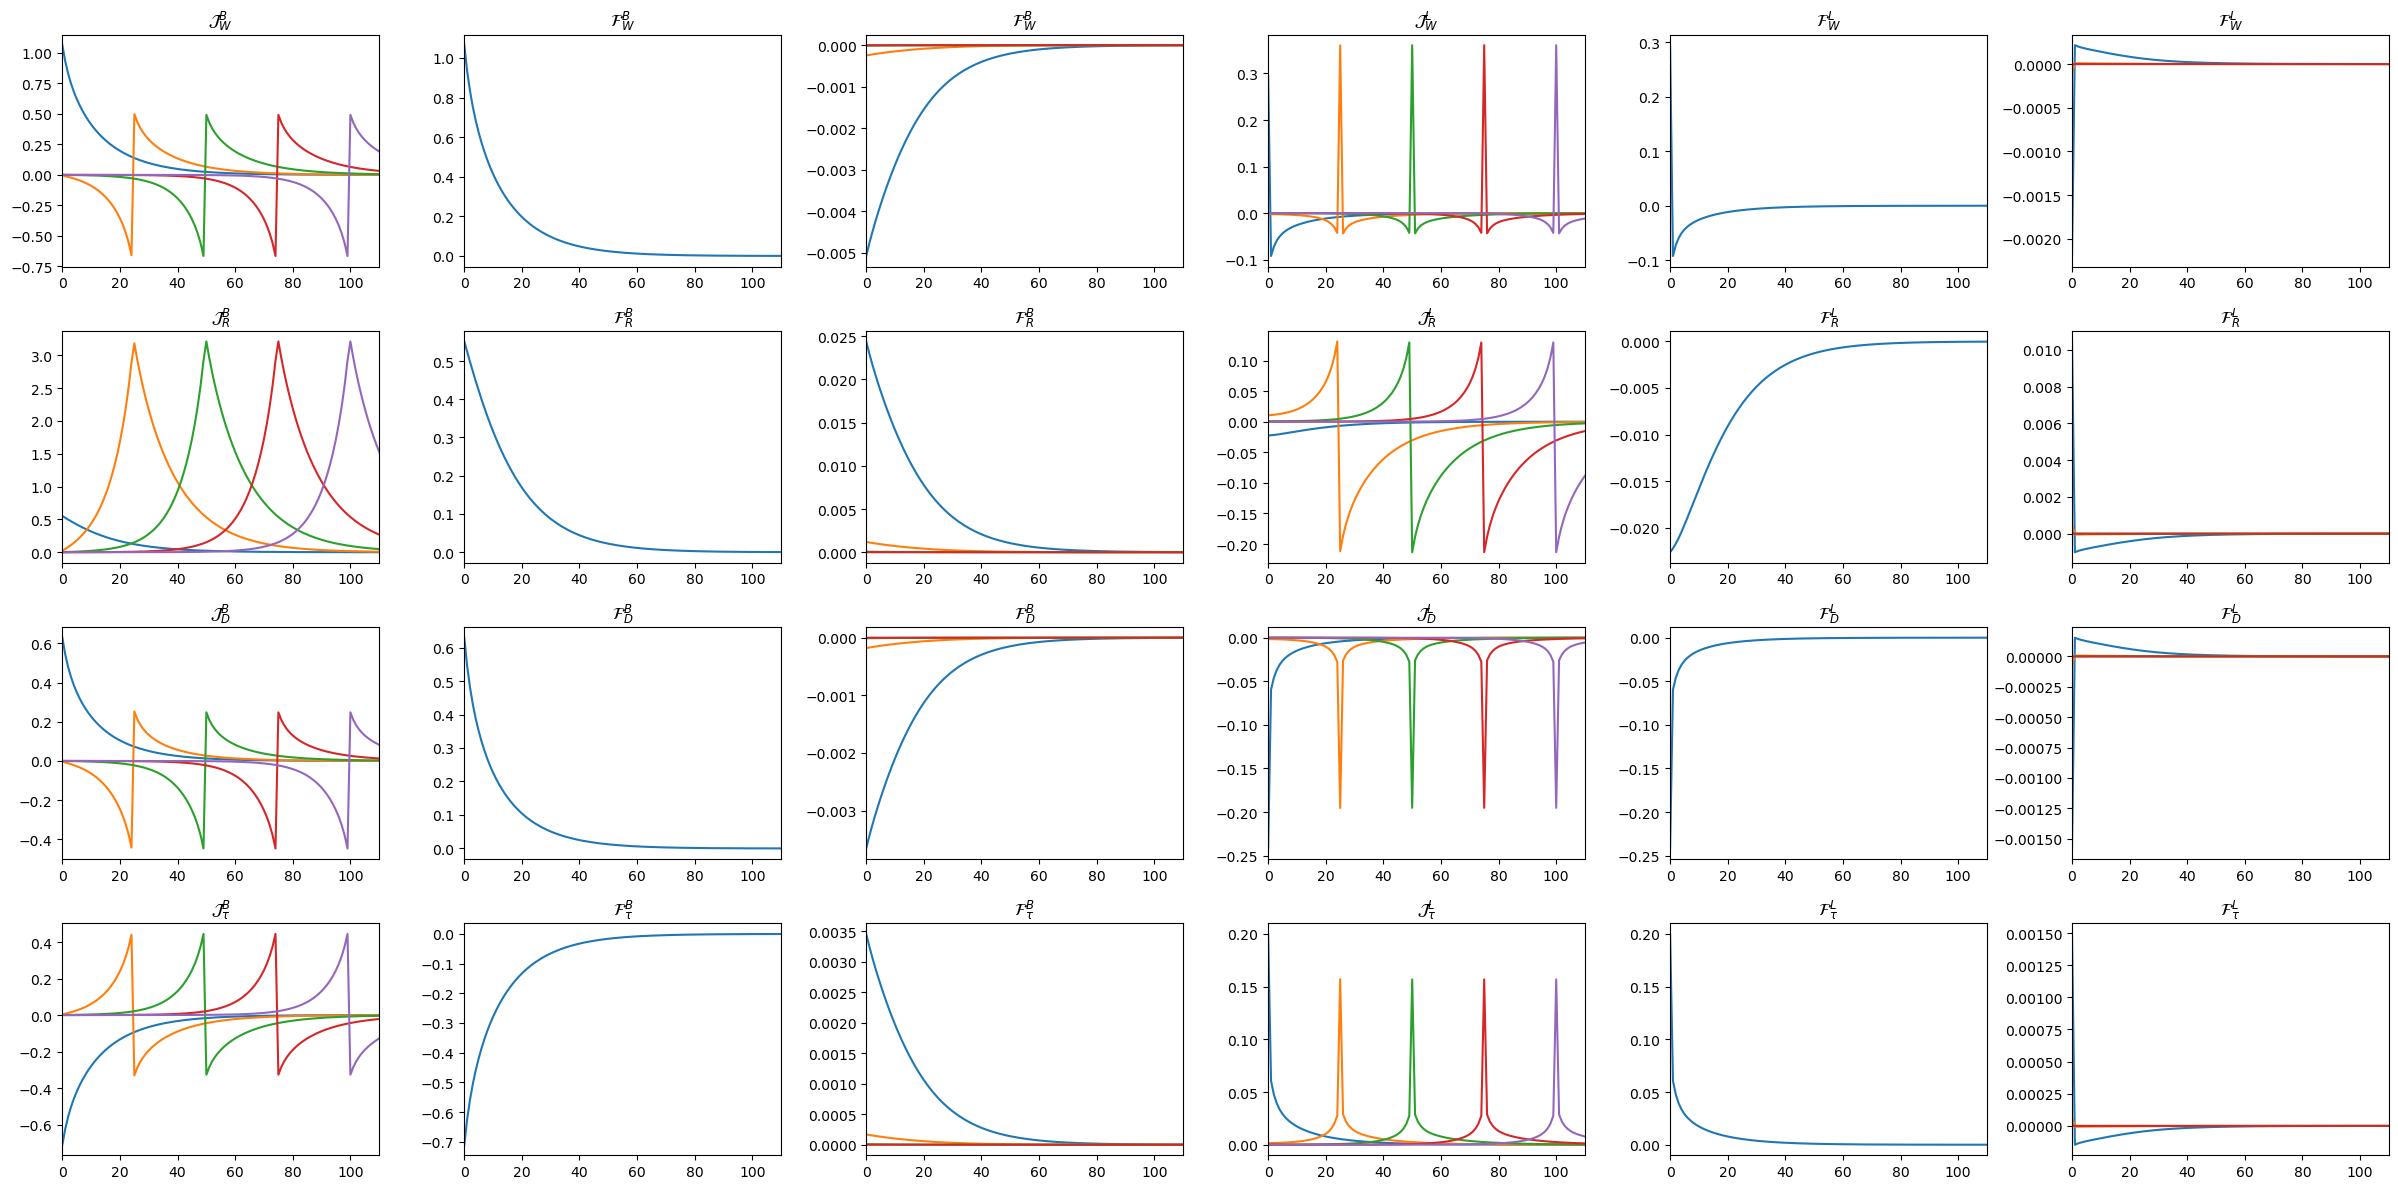

In [15]:
# calcualte jacobains
B_fake_news_mats, L_fake_news_mats, B_jacobians, L_jacobians = get_jacobians()

# plot
fig, axs = plt.subplots(4, 6)
fig.set_figwidth(24)
fig.set_figheight(12)
for i, indep_var in enumerate(['W', 'R', 'D', r'\tau']):
    axs[i, 0].set_title(r'$\mathcal{J}_' + indep_var + '^B$')
    axs[i, 1].set_title(r'$\mathcal{F}_' + indep_var + '^B$')
    axs[i, 2].set_title(r'$\mathcal{F}_' + indep_var + '^B$')
    axs[i, 3].set_title(r'$\mathcal{J}_' + indep_var + '^L$')
    axs[i, 4].set_title(r'$\mathcal{F}_' + indep_var + '^L$')
    axs[i, 5].set_title(r'$\mathcal{F}_' + indep_var + '^L$')

# times we'll have a line for
ts = np.arange(0, 101, 25)

# plot jacobians
for i in range(4):
    axs[i, 0].plot(B_jacobians[i][:, ts], label=ts)
    axs[i, 3].plot(L_jacobians[i][:, ts], label=ts)

# plot fake news mts
for i in range(4):
    axs[i, 1].plot(B_fake_news_mats[i][:, 0], label=0)
    axs[i, 2].plot(B_fake_news_mats[i][:, ts[1:]], label=ts[1:])
    axs[i, 4].plot(L_fake_news_mats[i][:, 0], label=0)
    axs[i, 5].plot(L_fake_news_mats[i][:, ts[1:]], label=ts[1:])

# final things
for i in range(axs.size):
    axs.take(i).set_xlim(0, ts[-1] * 1.1)
fig.tight_layout()

#### Make G
To calculate an IRF, we need to create the $\mathbf{G}$ matrix defined as
$$
    \mathbf{G} = -F_\mathbf{X}^{-1} F_\mathbf{Z}.
$$

The main step remaining is combining our Heterogeneous Block Jacobians using the chain rule and combining everything together. We know

\begin{align*}
    [(F_1)_Y]_{t, s} &= \frac{\partial N_t}{\partial Y_s} - \frac{\partial L_t}{\partial Y_s} = 1_{t = s} \frac{\partial N_t}{\partial Y_t} - \frac{\partial L_t}{\partial D_s} \frac{\partial D_s}{\partial Y_s} \\
    [(F_1)_W]_{t, s} &= \frac{\partial N_t}{\partial W_s} - \frac{\partial L_t}{\partial W_s} = -\frac{\partial L_t}{\partial W_s} - \frac{\partial L_t}{\partial D_s} \frac{\partial D_s}{\partial W_s} \\
    [(F_1)_{P^A}]_{t, s} &= \frac{\partial N_t}{\partial P_s^A} - \frac{\partial L_t}{\partial P_s^A} = -\frac{\partial L_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial P_s^A} - \frac{\partial L_t}{\partial R_s} \frac{\partial R_s}{\partial P_s^A} - \frac{\partial L_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial P_s^A} - \frac{\partial L_t}{\partial \tau_s} \frac{\partial R_s}{\partial \tau_s^A} \\
    [(F_1)_{P^B}]_{t, s} &= \frac{\partial N_t}{\partial P_s^B} - \frac{\partial L_t}{\partial P_s^B} = -\frac{\partial L_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial P_s^B} - \frac{\partial L_t}{\partial R_s} \frac{\partial R_s}{\partial P_s^B} - \frac{\partial L_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial P_s^B} - \frac{\partial L_t}{\partial \tau_s} \frac{\partial R_s}{\partial \tau_s^B} \\
    [(F_1)_Z]_{t, s} &= \frac{\partial N_t}{\partial Z_s} - \frac{\partial L_t}{\partial Z_s} = 1_{t = s} \frac{\partial N_t}{\partial Z_t} - \frac{\partial L_t}{\partial D_s} \frac{\partial D_s}{\partial Z_s} \\
    [(F_1)_\xi]_{t, s} &= \frac{\partial N_t}{\partial \xi_s} - \frac{\partial L_t}{\partial \xi_s} = -\frac{\partial L_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial \xi_s} - \frac{\partial L_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial \xi_s}
\end{align*}

and

\begin{align*}
    [(F_2)_Y]_{t, s} &= \frac{\partial B_t}{\partial Y_s} - \frac{\partial B}{\partial Y_s} = \frac{\partial B_t}{\partial D_s} \frac{\partial D_s}{\partial Y_s} \\
    [(F_2)_W]_{t, s} &= \frac{\partial B_t}{\partial W_s} - \frac{\partial B}{\partial W_s} = \frac{\partial B_t}{\partial W_s} + \frac{\partial B_t}{\partial D_s} \frac{\partial D_s}{\partial W_s} \\
    [(F_2)_{P^A}]_{t, s} &= \frac{\partial B_t}{\partial P_s^A} - \frac{\partial B}{\partial P_s^A} = \frac{\partial B_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial P_s^A} + \frac{\partial B_t}{\partial R_s} \frac{\partial R_s}{\partial P_s^A} + \frac{\partial B_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial P_s^A} + \frac{\partial B_t}{\partial \tau_s} \frac{\partial R_s}{\partial \tau_s^A} \\
    [(F_2)_{P^B}]_{t, s} &= \frac{\partial B_t}{\partial P_s^B} - \frac{\partial B}{\partial P_s^B} = \frac{\partial B_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial P_s^B} + \frac{\partial B_t}{\partial R_s} \frac{\partial R_s}{\partial P_s^B} + \frac{\partial B_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial P_s^B} + \frac{\partial B_t}{\partial \tau_s} \frac{\partial R_s}{\partial \tau_s^B} \\
    [(F_2)_Z]_{t, s} &= \frac{\partial B_t}{\partial Z_s} - \frac{\partial B}{\partial Z_s} = \frac{\partial B_t}{\partial D_s} \frac{\partial D_s}{\partial Z_s} \\
    [(F_2)_\xi]_{t, s} &= \frac{\partial B_t}{\partial \xi_s} - \frac{\partial B}{\partial \xi_s} = \frac{\partial B_t}{\partial R_{s+1}} \frac{\partial R_{s+1}}{\partial \xi_s} + \frac{\partial B_t}{\partial \tau_{s+1}} \frac{\partial \tau_{s+1}}{\partial \xi_s}
\end{align*}

In [16]:
@nb.njit
def jac_F1(jac_L_W=L_jacobians[0], jac_L_R=L_jacobians[1], jac_L_D=L_jacobians[2], jac_L_tau=L_jacobians[3],
    dN_dY_t=dN_dY_t, dD_dY_t=dD_dY_t, dD_dW_t=dD_dW_t, dR_dPA_t=dR_dPA_t, dR_dPA_l=dR_dPA_l, dtau_dPA_t=dtau_dPA_t, dtau_dPA_l=dtau_dPA_l, dR_dPB_t=dR_dPB_t,
    dR_dPB_l=dR_dPB_l, dtau_dPB_t=dtau_dPB_t, dtau_dPB_l=dtau_dPB_l, dN_dZ_t=dN_dZ_t, dD_dZ_t=dD_dZ_t, dR_dxi_l=dR_dxi_l, dtau_dxi_l=dtau_dxi_l, T=T):
    '''
    Make the jacobians of F1 with respect to the function variables
    '''
    jac_F1_Y = jac_L_D * dD_dY_t - dN_dY_t * np.eye(T)  # Y
    jac_F1_W = jac_L_W + jac_L_D * dD_dW_t  # W
    # jac_F1_PA = jac_L_R @ np.diag(np.full(T-1, dR_dPA_t), -1) + np.diag(np.full(T, dR_dPA_l)) + jac_L_tau @ np.diag(np.full(T-1, dtau_dPA_t), -1) + np.diag(np.full(T, dtau_dPA_l))
    # jac_F1_PB = jac_L_R @ np.diag(np.full(T-1, dR_dPB_t), -1) + np.diag(np.full(T, dR_dPB_l)) + jac_L_tau @ np.diag(np.full(T-1, dtau_dPB_t), -1) + np.diag(np.full(T, dtau_dPB_l))
    # jac_F1_PA = jac_L_R @ np.diag(np.full(T, dR_dPA_t)) + np.diag(np.full(T-1, dR_dPA_l), 1) + jac_L_tau @ np.diag(np.full(T, dtau_dPA_t)) + np.diag(np.full(T-1, dtau_dPA_l), 1)
    # jac_F1_PB = jac_L_R @ np.diag(np.full(T, dR_dPB_t)) + np.diag(np.full(T-1, dR_dPB_l), 1) + jac_L_tau @ np.diag(np.full(T, dtau_dPB_t)) + np.diag(np.full(T-1, dtau_dPB_l), 1)
    jac_F1_PA = jac_L_R * (dR_dPA_t + dR_dPA_l) + jac_L_tau * (dtau_dPA_t + dtau_dPA_l)  # PA, do i treat time right here?
    jac_F1_PB = jac_L_R * (dR_dPB_t + dR_dPB_l) + jac_L_tau * (dtau_dPB_t + dtau_dPB_l)  # PB, do i treat time right here?
    jac_F1_Z = jac_L_D * dD_dZ_t - dN_dZ_t * np.eye(T)  # Z
    jac_F1_xi = jac_L_R * dR_dxi_l + jac_L_tau * dtau_dxi_l  # xi, do i treat time right here?

    return jac_F1_Y, jac_F1_W, jac_F1_PA, jac_F1_PB, jac_F1_Z, jac_F1_xi


@nb.njit
def jac_F2(jac_B_W=B_jacobians[0], jac_B_R=B_jacobians[1], jac_B_D=B_jacobians[2], jac_B_tau=B_jacobians[3],
    dD_dY_t=dD_dY_t, dD_dW_t=dD_dW_t, dR_dPA_t=dR_dPA_t, dR_dPA_l=dR_dPA_l, dtau_dPA_t=dtau_dPA_t, dtau_dPA_l=dtau_dPA_l, dR_dPB_t=dR_dPB_t,
    dR_dPB_l=dR_dPB_l, dtau_dPB_t=dtau_dPB_t, dtau_dPB_l=dtau_dPB_l, dD_dZ_t=dD_dZ_t, dR_dxi_l=dR_dxi_l, dtau_dxi_l=dtau_dxi_l):
    '''
    Make the jacobians of F1 with respect to the function variables
    '''
    jac_F2_Y = jac_B_D * dD_dY_t  # Y
    jac_F2_W = jac_B_W + jac_B_D * dD_dW_t  # W
    # jac_F2_PA = jac_B_R @ np.diag(np.full(T-1, dR_dPA_t), -1) + np.diag(np.full(T, dR_dPA_l)) + jac_B_tau @ np.diag(np.full(T-1, dtau_dPA_t), -1) + np.diag(np.full(T, dtau_dPA_l))
    # jac_F2_PB = jac_B_R @ np.diag(np.full(T-1, dR_dPB_t), -1) + np.diag(np.full(T, dR_dPB_l)) + jac_B_tau @ np.diag(np.full(T-1, dtau_dPB_t), -1) + np.diag(np.full(T, dtau_dPB_l))
    # jac_F2_PA = jac_B_R @ np.diag(np.full(T, dR_dPA_t)) + np.diag(np.full(T-1, dR_dPA_l), 1) + jac_B_tau @ np.diag(np.full(T, dtau_dPA_t)) + np.diag(np.full(T-1, dtau_dPA_l), 1)
    # jac_F2_PB = jac_B_R @ np.diag(np.full(T, dR_dPB_t)) + np.diag(np.full(T-1, dR_dPB_l), 1) + jac_B_tau @ np.diag(np.full(T, dtau_dPB_t)) + np.diag(np.full(T-1, dtau_dPB_l), 1)
    jac_F2_PA = jac_B_R * (dR_dPA_t + dR_dPA_l) + jac_B_tau * (dtau_dPA_t + dtau_dPA_l)  # PA, do i treat time right here?
    jac_F2_PB = jac_B_R * (dR_dPB_t + dR_dPB_l) + jac_B_tau * (dtau_dPB_t + dtau_dPB_l)  # PB, do i treat time right here?
    jac_F2_Z = jac_B_D * dD_dZ_t  # Z
    jac_F2_xi = jac_B_R * dR_dxi_l + jac_B_tau * dtau_dxi_l  # xi, do i treat time right here?

    return jac_F2_Y, jac_F2_W, jac_F2_PA, jac_F2_PB, jac_F2_Z, jac_F2_xi


def jac_F():
    '''
    Get the jacobians for the model
    '''
    jac_F1_Y, jac_F1_W, jac_F1_PA, jac_F1_PB, jac_F1_Z, jac_F1_xi = jac_F1()
    jac_F2_Y, jac_F2_W, jac_F2_PA, jac_F2_PB, jac_F2_Z, jac_F2_xi = jac_F2()
    jac_F3_Y, jac_F3_W, jac_F3_PA, jac_F3_PB, jac_F3_Z, jac_F3_xi = jac_F3(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t)
    jac_F4_Y, jac_F4_W, jac_F4_PA, jac_F4_PB, jac_F4_Z, jac_F4_xi = jac_F4(dR_dPA_l, dR_dPB_l, dR_dxi_l, dR_dPA_t, dR_dPB_t)

    jac_X = np.block([[jac_F1_Y, jac_F1_W, jac_F1_PA, jac_F1_PB],
                      [jac_F2_Y, jac_F2_W, jac_F2_PA, jac_F2_PB],
                      [jac_F3_Y, jac_F3_W, jac_F3_PA, jac_F3_PB],
                      [jac_F4_Y, jac_F4_W, jac_F4_PA, jac_F4_PB]])
    jac_Z = np.block([[jac_F1_Z, jac_F1_xi],
                      [jac_F2_Z, jac_F2_xi],
                      [jac_F3_Z, jac_F3_xi],
                      [jac_F4_Z, jac_F4_xi]])
    
    return jac_X, jac_Z

# keep jits compilled

In [17]:
# make G
jac_X, jac_Z = jac_F()
G = -np.linalg.solve(jac_X, jac_Z)

#### IRF
Use the matrices we've created to calculate an IRF.

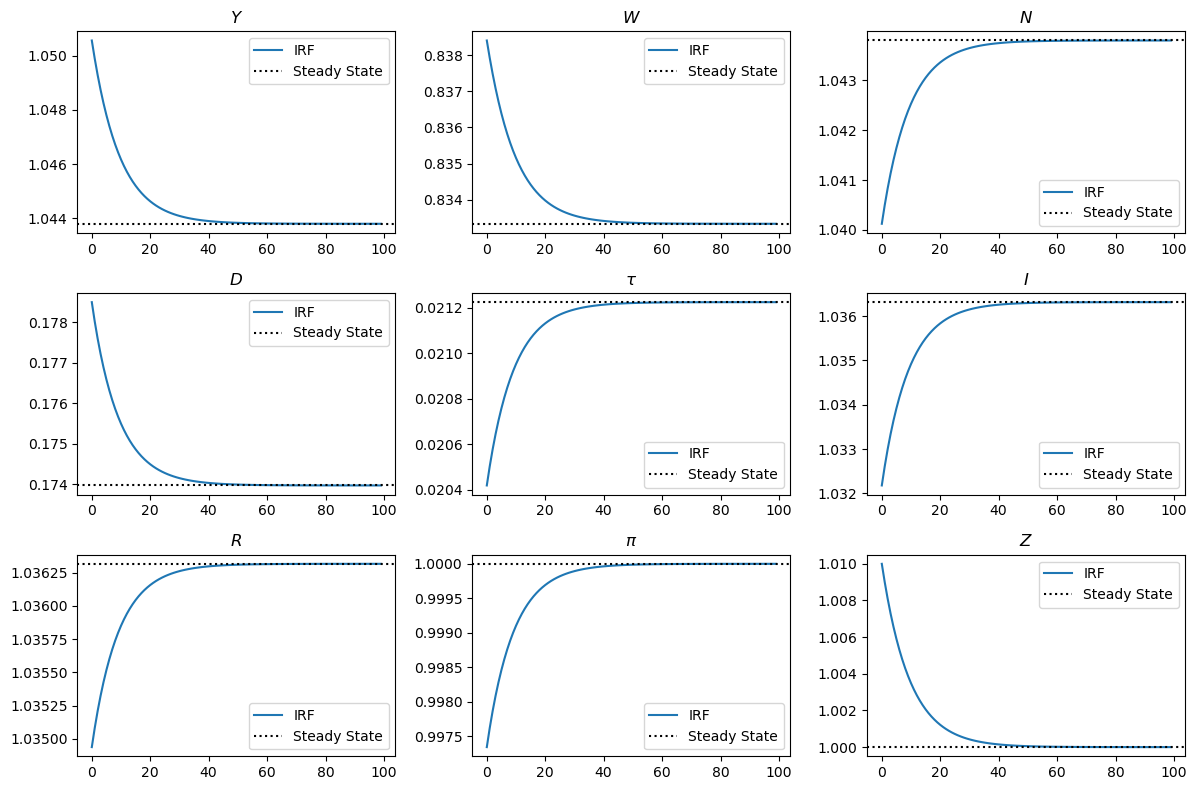

In [18]:
## TFP shock
# solve for variables
dY_path, dW_path, dPA_path, dPB_path = (G @ np.hstack((dZ_path, np.zeros(T)))).reshape((-1, 4), order='F').T

# get other paths, we use a linear extension since everyhting were doing is linearized
dN_path = dY_path * dN_dY_t + dZ_path * dN_dZ_t
dD_path = dY_path * dD_dY_t + dW_path * dD_dW_t + dZ_path * dD_dZ_t
dtau_path = dPA_path * (dtau_dPA_l + dtau_dPA_t) + dPB_path * (dtau_dPB_l + dtau_dPB_t)
dI_path = dPA_path * dI_dPA_t + dPB_path * dI_dPB_t
dR_path = dPA_path * (dR_dPA_l + dR_dPA_t) + dPB_path * (dR_dPB_l + dR_dPB_t)
dpi_path = dPA_path * dpi_dPA_t + dPB_path * dpi_dPB_t
Y_path = Y_ss + dY_path
W_path = W_ss + dW_path
N_path = N_ss + dN_path
D_path = D_ss + dD_path
tau_path = tau_ss + dtau_path
I_path = I_ss + dI_path
R_path = R_ss + dR_path
pi_path = pi_ss + dpi_path
Z_path = Z_ss + dZ_path

# plot
t = 100
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
titles = ['$Y$', '$W$', '$N$', '$D$', r'$\tau$', '$I$', '$R$', r'$\pi$', '$Z$']
paths = [Y_path, W_path, N_path, D_path, tau_path, I_path, R_path, pi_path, Z_path]
X_ss = [Y_ss, W_ss, N_ss, D_ss, tau_ss, I_ss, R_ss, pi_ss, Z_ss]
for i in range(9):
    ax = axs.take(i)
    ax.plot(paths[i][:t], label='IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
fig.tight_layout()

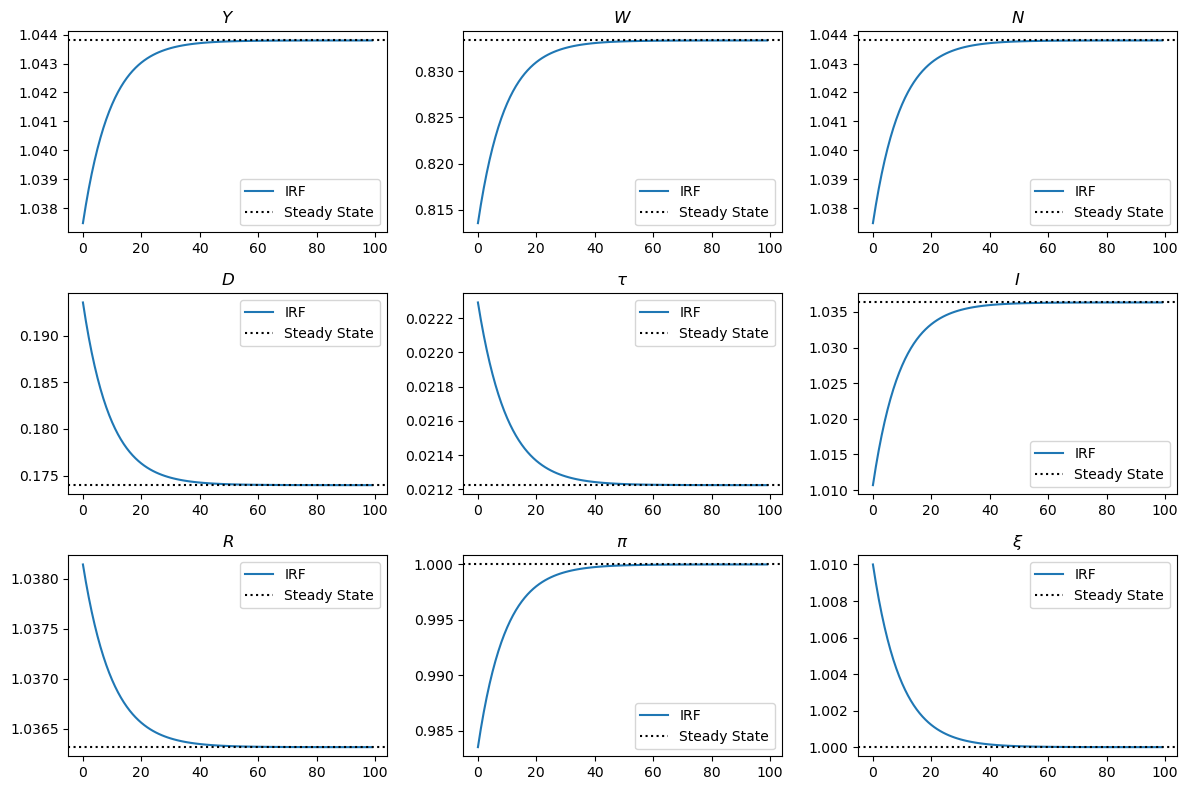

In [19]:
## montary polciy shock
# solve for variables
dY_path, dW_path, dPA_path, dPB_path = (G @ np.hstack((np.zeros(T), dxi_path))).reshape((-1, 4), order='F').T

# get other paths, we use a linear extension since everyhting were doing is linearized
dN_path = dY_path * dN_dY_t
dD_path = dY_path * dD_dY_t + dW_path * dD_dW_t
dtau_path = dPA_path * (dtau_dPA_l + dtau_dPA_t) + dPB_path * (dtau_dPB_l + dtau_dPB_t) + dxi_path * dtau_dxi_l
dI_path = dPA_path * dI_dPA_t + dPB_path * dI_dPB_t
dR_path = dPA_path * (dR_dPA_l + dR_dPA_t) + dPB_path * (dR_dPB_l + dR_dPB_t) + dxi_path * dR_dxi_l
dpi_path = dPA_path * dpi_dPA_t + dPB_path * dpi_dPB_t
Y_path = Y_ss + dY_path
W_path = W_ss + dW_path
N_path = N_ss + dN_path
D_path = D_ss + dD_path
tau_path = tau_ss + dtau_path
I_path = I_ss + dI_path
R_path = R_ss + dR_path
pi_path = pi_ss + dpi_path
xi_path = xi_ss + dxi_path

# plot
t = 100
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(8)
titles = ['$Y$', '$W$', '$N$', '$D$', r'$\tau$', '$I$', '$R$', r'$\pi$', r'$\xi$']
paths = [Y_path, W_path, N_path, D_path, tau_path, I_path, R_path, pi_path, xi_path]
X_ss = [Y_ss, W_ss, N_ss, D_ss, tau_ss, I_ss, R_ss, pi_ss, xi_ss]
for i in range(9):
    ax = axs.take(i)
    ax.plot(paths[i][:t], label='IRF')
    ax.axhline(X_ss[i], color='k', linestyle=':', label="Steady State")
    ax.set_title(titles[i])
    ax.legend()
fig.tight_layout()

#### Simulate Individuals
Finally, we'll reiterate backwards and find the derivatives of the policy rules and distribution of wealth so we can simulate a panel of individuals within the model.

In [20]:
def policy_back_iter(i, T=T, V_a_ss=V_a_ss, a_ss=a_ss, tran_mat_ss=tran_mat_ss, W_ss=W_ss, R_ss=R_ss, D_ss=D_ss, tau_ss=tau_ss, h=1e-7):
    '''
    Backwards iterate to make the distributions and output effects at each time
    '''
    # setup
    d_input = np.array([W_ss, R_ss, D_ss, tau_ss]) + np.eye(1, 4, i)[0] * h  # perturb input
    da_t_path = np.empty((T, N_A, N_z))  # dx_t_path[s] represents the effect on policy functions at time 0 of a shock at time s
    dc_t_path = np.empty((T, N_A, N_z))
    dl_t_path = np.empty((T, N_A, N_z))
    dtran_mat_path = []  # dtran_mat_path[s] represeants the effect on transition probabilities at time 0 of a shock at time s
    corrected_V_a_t, corrected_a_t, corrected_c_t, corrected_l_t = euler_back(V_a_ss, W_ss, R_ss, D_ss, tau_ss)  # subtract this out each period so the steady state stays centered

    # get initial period, pertubed R_t or W_t
    V_a_t, a_t, c_t, l_t = euler_back(V_a_ss, *d_input)
    dV_a_t, da_t, dc_t, dl_t = V_a_t - corrected_V_a_t, a_t - corrected_a_t, c_t - corrected_c_t, l_t - corrected_l_t    # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
    da_t_path[0] = da_t / h
    dc_t_path[0] = dc_t / h
    dl_t_path[0] = dl_t / h
    dtran_mat = make_tran_mat(da_t + a_ss) - tran_mat_ss  # cant be njited
    dtran_mat_path.append(dtran_mat)

    # get later periods, R_ss and W_ss
    for s in range(1, T):
        V_a_t, a_t, _, l_t = euler_back(V_a_ss + dV_a_t, W_ss, R_ss, D_ss, tau_ss)
        dV_a_t, da_t, dc_t, dl_t = V_a_t - corrected_V_a_t, a_t - corrected_a_t, c_t - corrected_c_t, l_t - corrected_l_t    # we subtract corrected_b_l to avoid numerical errors from an imperfect steady state (idk if this works tbh)
        da_t_path[s] = da_t / h
        dc_t_path[s] = dc_t / h
        dl_t_path[s] = dl_t / h
        dtran_mat = make_tran_mat(da_t + a_ss) - tran_mat_ss  # cant be njited
        dtran_mat_path.append(dtran_mat)

    return da_t_path, dc_t_path, dl_t_path, np.array(dtran_mat_path)


def get_dvar_path(dvar_X, dX_path, T=T):  # equation 88!!!
    '''
    Applys chain rule to get the path for some variables based on its derivative with respect to X
    '''
    # chain rule matrix
    chain = np.zeros((T, T))
    rows, tri_cols = np.triu_indices(T)
    cols = tri_cols - np.repeat(np.arange(T), T-np.arange(T))  # adjust to left side
    chain[rows, cols] = dX_path[tri_cols]

    # make path
    dvar_path = (dvar_X.T @ chain).T

    return dvar_path


def get_ddist_path(dtran_mat_path, tran_mat_ss=tran_mat_ss, dist_ss=dist_ss, T=T):
    '''
    Create the path for the changes in the distribution
    '''
    ddist_path = np.empty((T,) + dist_ss.shape)  # db_l_path[s] represents the effect on policy functions at time 0 of a shock at time s

    # create path
    ddist_path[0] = (dtran_mat_path[0] @ dist_ss.ravel('F')).reshape((-1, N_z), order='F')
    for t in range(1, T):
        ddist_path[t] = (tran_mat_ss @ ddist_path[t-1].ravel('F') + dtran_mat_path[t] @ dist_ss.ravel('F')).reshape((-1, N_z), order='F')

    return ddist_path


# get rules
da_t_dW, dc_t_dW, dl_t_dW, dtran_mat_dW = policy_back_iter(0)
da_t_dR, dc_t_dR, dl_t_dR, dtran_mat_dR = policy_back_iter(1)
da_t_dD, dc_t_dD, dl_t_dD, dtran_mat_dD = policy_back_iter(2)
da_t_dtau, dc_t_dtau, dl_t_dtau, dtran_mat_dtau = policy_back_iter(3)

# get paths
da_t_path = get_dvar_path(da_t_dW, dW_path) + get_dvar_path(da_t_dR, dR_path) + get_dvar_path(da_t_dD, dD_path) + get_dvar_path(da_t_dtau, dtau_path)
dc_t_path = get_dvar_path(dc_t_dW, dW_path) + get_dvar_path(dc_t_dR, dR_path) + get_dvar_path(dc_t_dD, dD_path) + get_dvar_path(dc_t_dtau, dtau_path)
dl_t_path = get_dvar_path(dl_t_dW, dW_path) + get_dvar_path(dl_t_dR, dR_path) + get_dvar_path(dl_t_dD, dD_path) + get_dvar_path(dl_t_dtau, dtau_path)
dtran_mat_path = get_dvar_path(dtran_mat_dW, dW_path) + get_dvar_path(dtran_mat_dR, dR_path) + get_dvar_path(dtran_mat_dD, dD_path) + get_dvar_path(dtran_mat_dtau, dtau_path)  # this line takes most the time here
ddist_path = get_ddist_path(dtran_mat_path)
dist_path = dist_ss + ddist_path
a_t_path = a_ss + da_t_path
c_t_path = c_ss + dc_t_path
l_t_path = l_ss + dl_t_path

In [21]:
# animation
# setup plot
n = (GRID <= 25).sum()  # look at first n gridpoits, most the interesting stuff happens early
fig, axs = plt.subplots(2, 3)
fig.suptitle('t=0')
fig.set_figwidth(12)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Asset Distribution')
axtop.set_xlabel('Assets')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 1.1*max([d.max() for d in dist_path])))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, GRID[n-1]))
axs[1, 0].axhline(0., color='k', linestyle=':')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, GRID[n-1]))
axs[1, 1].axhline(0., color='k', linestyle=':')
axs[1, 2].set_title('Labor Function')
axs[1, 2].set_xlabel('This Period Assets')
axs[1, 2].set_ylabel('% Deviation from Steady State')
axs[1, 2].set_xlim((A_MIN, GRID[n-1]))
axs[1, 2].axhline(0., color='k', linestyle=':')

# plot it
lns_dist = axtop.plot([0], np.array([[0] for _ in range(N_z)]).T, label=['$z_{i, t}='+str(round(z, 2))+'$' for z in grid_z])
lns_a = axs[1, 0].plot([0], np.array([[0] for _ in range(N_z)]).T)
lns_c = axs[1, 1].plot([0], np.array([[0] for _ in range(N_z)]).T)
lns_l = axs[1, 2].plot([0], np.array([[0] for _ in range(N_z)]).T)

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t].T
    for ln, dist_z in zip(lns_dist, dist_t):
        ln.set_data(GRID, dist_z)

    # update savings
    a_t = a_t_path[t]
    da_t = ((a_t - a_ss) / np.where(a_ss != 0, a_ss, 1.)).T
    for ln, da_t_z in zip(lns_a, da_t):
        ln.set_data(GRID, da_t_z)

    # update savings
    c_t = c_t_path[t]
    dc_t = ((c_t - c_ss) / np.where(c_ss != 0, c_ss, 1.)).T
    for ln, dc_t_z in zip(lns_c, dc_t):
        ln.set_data(GRID, dc_t_z)

    # update savings
    l_t = l_t_path[t]
    dl_t = ((l_t - l_ss) / np.where(l_ss != 0, l_ss, 1.)).T
    for ln, dl_t_z in zip(lns_l, dl_t):
        ln.set_data(GRID, dl_t_z)

# make video
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=100, interval=50, repeat=False)  # only look at first few hundred periods
HTML(anim.to_html5_video())